<a href="https://colab.research.google.com/github/VLCHS/FCNN/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb==0.18.7
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 17.4 MB/s eta 0:00:00


In [2]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [3]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using gpu device


In [4]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [5]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

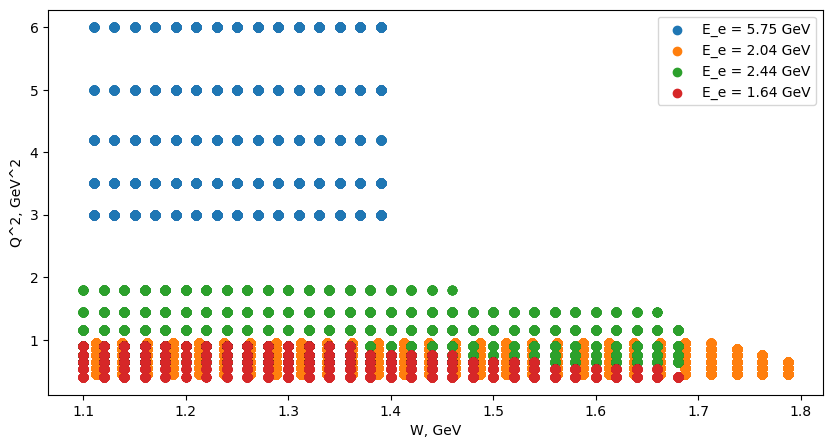

In [6]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [7]:
# Initialize wandb
run = wandb.init(project="FCNN for ep->ep_pi0, unified topology")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
class MAELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mae = nn.L1Loss()

    def forward(self,x,y):
        return self.mae(x,y)

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': False,
    'feature_scaler': StandardScaler(),   #Standard and MinMax are pretty good
    'label_scaler': StandardScaler(),
    'augment': False,
    'augment_factor': 2,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': MAELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 20,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        #df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(train_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_train_df = pd.concat([train_df, aug_df], ignore_index=True)
            train_label_data = augment_train_df["dsigma_dOmega"]
            train_feature_data = augment_train_df.loc[:, ~augment_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=2)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [9]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: True (cuda), used: True


2024-12-11 09:37:24,442 : INFO : GPU available: True (cuda), used: True


INFO: TPU available: False, using: 0 TPU cores


2024-12-11 09:37:24,447 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2024-12-11 09:37:24,452 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2024-12-11 09:37:24,459 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2024-12-11 09:37:25,105 : INFO : LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | MAELoss             | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


2024-12-11 09:37:25,305 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | MAELoss             | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
2024-12-11 09:37:25,464 : INFO : Training is starting
2024-12-11 09:37:31,696 : INFO : epoch: 0; val_loss: 1.5276620388031006
2024-

INFO: Metric val_loss improved. New best score: 1.528


2024-12-11 09:37:31,739 : INFO : Metric val_loss improved. New best score: 1.528
2024-12-11 09:37:31,841 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=1.52766-epoch=00.ckpt
2024-12-11 09:37:38,445 : INFO : epoch: 1; val_loss: 1.5948383808135986
2024-12-11 09:37:38,461 : INFO : epoch: 1; train_loss: 1.4044697284698486
2024-12-11 09:37:38,605 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=1.59484-epoch=01.ckpt
2024-12-11 09:37:43,561 : INFO : epoch: 2; val_loss: 1.1826183795928955
2024-12-11 09:37:43,571 : INFO : epoch: 2; train_loss: 1.0099157094955444


INFO: Metric val_loss improved by 0.345 >= min_delta = 1e-05. New best score: 1.183


2024-12-11 09:37:43,600 : INFO : Metric val_loss improved by 0.345 >= min_delta = 1e-05. New best score: 1.183
2024-12-11 09:37:43,703 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=1.18262-epoch=02.ckpt
2024-12-11 09:37:51,168 : INFO : epoch: 3; val_loss: 0.9710952043533325
2024-12-11 09:37:51,185 : INFO : epoch: 3; train_loss: 0.8771879076957703


INFO: Metric val_loss improved by 0.212 >= min_delta = 1e-05. New best score: 0.971


2024-12-11 09:37:51,222 : INFO : Metric val_loss improved by 0.212 >= min_delta = 1e-05. New best score: 0.971
2024-12-11 09:37:51,373 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.97110-epoch=03.ckpt
2024-12-11 09:37:56,916 : INFO : epoch: 4; val_loss: 0.8733171820640564
2024-12-11 09:37:56,930 : INFO : epoch: 4; train_loss: 0.8273741602897644


INFO: Metric val_loss improved by 0.098 >= min_delta = 1e-05. New best score: 0.873


2024-12-11 09:37:56,953 : INFO : Metric val_loss improved by 0.098 >= min_delta = 1e-05. New best score: 0.873
2024-12-11 09:37:57,057 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.87332-epoch=04.ckpt
2024-12-11 09:38:01,983 : INFO : epoch: 5; val_loss: 0.8341639637947083
2024-12-11 09:38:01,995 : INFO : epoch: 5; train_loss: 0.7744578719139099


INFO: Metric val_loss improved by 0.039 >= min_delta = 1e-05. New best score: 0.834


2024-12-11 09:38:02,021 : INFO : Metric val_loss improved by 0.039 >= min_delta = 1e-05. New best score: 0.834
2024-12-11 09:38:02,127 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.83416-epoch=05.ckpt
2024-12-11 09:38:08,533 : INFO : epoch: 6; val_loss: 0.6672637462615967
2024-12-11 09:38:08,546 : INFO : epoch: 6; train_loss: 0.7337148189544678


INFO: Metric val_loss improved by 0.167 >= min_delta = 1e-05. New best score: 0.667


2024-12-11 09:38:08,572 : INFO : Metric val_loss improved by 0.167 >= min_delta = 1e-05. New best score: 0.667
2024-12-11 09:38:08,686 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.66726-epoch=06.ckpt
2024-12-11 09:38:13,811 : INFO : epoch: 7; val_loss: 0.8059141635894775
2024-12-11 09:38:13,822 : INFO : epoch: 7; train_loss: 0.7095240354537964
2024-12-11 09:38:13,955 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.80591-epoch=07.ckpt
2024-12-11 09:38:20,626 : INFO : epoch: 8; val_loss: 0.8883898258209229
2024-12-11 09:38:20,639 : INFO : epoch: 8; train_loss: 0.6921923756599426
2024-12-11 09:38:25,783 : INFO : epoch: 9; val_loss: 0.8075190782546997
2024-12-11 09:38:25,796 : INFO : epoch: 9; train_loss: 0.7231740951538086
2024-12-11 09:38:25,937 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, u

INFO: Metric val_loss improved by 0.102 >= min_delta = 1e-05. New best score: 0.565


2024-12-11 09:38:37,665 : INFO : Metric val_loss improved by 0.102 >= min_delta = 1e-05. New best score: 0.565
2024-12-11 09:38:37,776 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.56544-epoch=11.ckpt
2024-12-11 09:38:42,905 : INFO : epoch: 12; val_loss: 0.5851868391036987
2024-12-11 09:38:42,916 : INFO : epoch: 12; train_loss: 0.6045121550559998
2024-12-11 09:38:43,046 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.58519-epoch=12.ckpt
2024-12-11 09:38:49,889 : INFO : epoch: 13; val_loss: 0.6339554786682129
2024-12-11 09:38:49,903 : INFO : epoch: 13; train_loss: 0.5769873261451721
2024-12-11 09:38:50,080 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.63396-epoch=13.ckpt
2024-12-11 09:38:55,735 : INFO : epoch: 14; val_loss: 0.

INFO: Metric val_loss improved by 0.023 >= min_delta = 1e-05. New best score: 0.543


2024-12-11 09:39:00,705 : INFO : Metric val_loss improved by 0.023 >= min_delta = 1e-05. New best score: 0.543
2024-12-11 09:39:00,864 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.54252-epoch=15.ckpt
2024-12-11 09:39:07,102 : INFO : epoch: 16; val_loss: 0.6566197872161865
2024-12-11 09:39:07,114 : INFO : epoch: 16; train_loss: 0.5678399205207825
2024-12-11 09:39:11,996 : INFO : epoch: 17; val_loss: 0.7431117296218872
2024-12-11 09:39:12,007 : INFO : epoch: 17; train_loss: 0.5813450217247009
2024-12-11 09:39:18,331 : INFO : epoch: 18; val_loss: 0.5835483074188232
2024-12-11 09:39:18,342 : INFO : epoch: 18; train_loss: 0.5839810371398926
2024-12-11 09:39:18,475 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.58355-epoch=18.ckpt
2024-12-11 09:39:23,539 : INFO : epoch: 19; val_loss: 0.6118771433830261
2024-12-11 09:

INFO: Metric val_loss improved by 0.029 >= min_delta = 1e-05. New best score: 0.513


2024-12-11 09:39:28,880 : INFO : Metric val_loss improved by 0.029 >= min_delta = 1e-05. New best score: 0.513
2024-12-11 09:39:29,053 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.51332-epoch=20.ckpt
2024-12-11 09:39:35,596 : INFO : epoch: 21; val_loss: 0.6086406707763672
2024-12-11 09:39:35,608 : INFO : epoch: 21; train_loss: 0.5711169242858887
2024-12-11 09:39:40,565 : INFO : epoch: 22; val_loss: 0.594024658203125
2024-12-11 09:39:40,578 : INFO : epoch: 22; train_loss: 0.5692437887191772
2024-12-11 09:39:46,954 : INFO : epoch: 23; val_loss: 0.5549652576446533
2024-12-11 09:39:46,965 : INFO : epoch: 23; train_loss: 0.569939136505127
2024-12-11 09:39:47,157 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.55497-epoch=23.ckpt
2024-12-11 09:39:52,487 : INFO : epoch: 24; val_loss: 0.5714224576950073
2024-12-11 09:39

INFO: Metric val_loss improved by 0.018 >= min_delta = 1e-05. New best score: 0.495


2024-12-11 09:40:25,029 : INFO : Metric val_loss improved by 0.018 >= min_delta = 1e-05. New best score: 0.495
2024-12-11 09:40:25,136 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.49486-epoch=30.ckpt
2024-12-11 09:40:31,439 : INFO : epoch: 31; val_loss: 0.49731916189193726
2024-12-11 09:40:31,451 : INFO : epoch: 31; train_loss: 0.532278835773468
2024-12-11 09:40:31,579 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.49732-epoch=31.ckpt
2024-12-11 09:40:36,498 : INFO : epoch: 32; val_loss: 0.6003021001815796
2024-12-11 09:40:36,510 : INFO : epoch: 32; train_loss: 0.5304792523384094
2024-12-11 09:40:42,753 : INFO : epoch: 33; val_loss: 0.5024225115776062
2024-12-11 09:40:42,767 : INFO : epoch: 33; train_loss: 0.519676685333252
2024-12-11 09:40:42,959 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_p

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.494


2024-12-11 09:40:52,967 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.494
2024-12-11 09:40:53,077 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.49428-epoch=35.ckpt
2024-12-11 09:40:59,469 : INFO : epoch: 36; val_loss: 0.501017689704895
2024-12-11 09:40:59,481 : INFO : epoch: 36; train_loss: 0.5166617631912231
2024-12-11 09:41:04,483 : INFO : epoch: 37; val_loss: 0.5309507846832275
2024-12-11 09:41:04,494 : INFO : epoch: 37; train_loss: 0.512139081954956
2024-12-11 09:41:10,827 : INFO : epoch: 38; val_loss: 0.5027509331703186
2024-12-11 09:41:10,839 : INFO : epoch: 38; train_loss: 0.5145661234855652
2024-12-11 09:41:16,003 : INFO : epoch: 39; val_loss: 0.5113505721092224
2024-12-11 09:41:16,014 : INFO : epoch: 39; train_loss: 0.5149715542793274
2024-12-11 09:41:21,005 : INFO : epoch: 40; val_loss: 0.524406373500824
2024-12-11 09:41:21,020 : INFO : epoch: 40; trai

INFO: Metric val_loss improved by 0.010 >= min_delta = 1e-05. New best score: 0.484


2024-12-11 09:41:55,110 : INFO : Metric val_loss improved by 0.010 >= min_delta = 1e-05. New best score: 0.484
2024-12-11 09:41:55,214 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.48396-epoch=46.ckpt
2024-12-11 09:42:00,234 : INFO : epoch: 47; val_loss: 0.4972182810306549
2024-12-11 09:42:00,246 : INFO : epoch: 47; train_loss: 0.492622435092926
2024-12-11 09:42:05,753 : INFO : epoch: 48; val_loss: 0.47615113854408264
2024-12-11 09:42:05,767 : INFO : epoch: 48; train_loss: 0.4951336085796356


INFO: Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.476


2024-12-11 09:42:05,800 : INFO : Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.476
2024-12-11 09:42:05,962 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.47615-epoch=48.ckpt
2024-12-11 09:42:11,565 : INFO : epoch: 49; val_loss: 0.5280469655990601
2024-12-11 09:42:11,576 : INFO : epoch: 49; train_loss: 0.4946376383304596
2024-12-11 09:42:16,471 : INFO : epoch: 50; val_loss: 0.4836917519569397
2024-12-11 09:42:16,483 : INFO : epoch: 50; train_loss: 0.503843367099762
2024-12-11 09:42:16,618 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.48369-epoch=50.ckpt
2024-12-11 09:42:23,016 : INFO : epoch: 51; val_loss: 0.4873025417327881
2024-12-11 09:42:23,029 : INFO : epoch: 51; train_loss: 0.49369171261787415
2024-12-11 09:42:27,924 : INFO : epoch: 52; val_loss: 0.4796175956726074
2024-12-11 09:

INFO: Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.472


2024-12-11 09:42:57,229 : INFO : Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.472
2024-12-11 09:42:57,372 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.47173-epoch=57.ckpt
2024-12-11 09:43:03,853 : INFO : epoch: 58; val_loss: 0.5074482560157776
2024-12-11 09:43:03,864 : INFO : epoch: 58; train_loss: 0.4895002543926239
2024-12-11 09:43:08,783 : INFO : epoch: 59; val_loss: 0.481531023979187
2024-12-11 09:43:08,794 : INFO : epoch: 59; train_loss: 0.49373406171798706
2024-12-11 09:43:14,298 : INFO : epoch: 60; val_loss: 0.4926573634147644
2024-12-11 09:43:14,312 : INFO : epoch: 60; train_loss: 0.49251773953437805
2024-12-11 09:43:20,327 : INFO : epoch: 61; val_loss: 0.4884398579597473
2024-12-11 09:43:20,340 : INFO : epoch: 61; train_loss: 0.4887400269508362
2024-12-11 09:43:25,511 : INFO : epoch: 62; val_loss: 0.4957723021507263
2024-12-11 09:43:25,522 : INFO : epoch: 62; 

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.470


2024-12-11 09:44:17,218 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.470
2024-12-11 09:44:17,322 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.47047-epoch=71.ckpt
2024-12-11 09:44:22,351 : INFO : epoch: 72; val_loss: 0.5097596645355225
2024-12-11 09:44:22,364 : INFO : epoch: 72; train_loss: 0.48057523369789124
2024-12-11 09:44:28,806 : INFO : epoch: 73; val_loss: 0.47761091589927673
2024-12-11 09:44:28,817 : INFO : epoch: 73; train_loss: 0.48196032643318176
2024-12-11 09:44:33,839 : INFO : epoch: 74; val_loss: 0.47458893060684204
2024-12-11 09:44:33,850 : INFO : epoch: 74; train_loss: 0.4804985821247101
2024-12-11 09:44:33,972 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.47459-epoch=74.ckpt
2024-12-11 09:44:39,653 : INFO : epoch: 75; val_loss: 0.4803149104118347
2024-12-11

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.470


2024-12-11 09:45:13,742 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.470
2024-12-11 09:45:13,853 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.47005-epoch=81.ckpt
2024-12-11 09:45:18,840 : INFO : epoch: 82; val_loss: 0.4737929105758667
2024-12-11 09:45:18,851 : INFO : epoch: 82; train_loss: 0.47144994139671326
2024-12-11 09:45:24,985 : INFO : epoch: 83; val_loss: 0.4757453203201294
2024-12-11 09:45:24,997 : INFO : epoch: 83; train_loss: 0.4720872938632965
2024-12-11 09:45:30,009 : INFO : epoch: 84; val_loss: 0.4707987308502197
2024-12-11 09:45:30,021 : INFO : epoch: 84; train_loss: 0.47165632247924805
2024-12-11 09:45:30,145 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.47080-epoch=84.ckpt
2024-12-11 09:45:35,754 : INFO : epoch: 85; val_loss: 0.4722858667373657
2024-12-11 0

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.469


2024-12-11 09:46:03,474 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.469
2024-12-11 09:46:03,591 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46947-epoch=90.ckpt
2024-12-11 09:46:10,301 : INFO : epoch: 91; val_loss: 0.47998830676078796
2024-12-11 09:46:10,314 : INFO : epoch: 91; train_loss: 0.47340893745422363
2024-12-11 09:46:15,232 : INFO : epoch: 92; val_loss: 0.47840625047683716
2024-12-11 09:46:15,244 : INFO : epoch: 92; train_loss: 0.47184720635414124
2024-12-11 09:46:21,111 : INFO : epoch: 93; val_loss: 0.468202143907547
2024-12-11 09:46:21,124 : INFO : epoch: 93; train_loss: 0.47124412655830383


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.468


2024-12-11 09:46:21,158 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.468
2024-12-11 09:46:21,355 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46820-epoch=93.ckpt
2024-12-11 09:46:26,719 : INFO : epoch: 94; val_loss: 0.4710428714752197
2024-12-11 09:46:26,731 : INFO : epoch: 94; train_loss: 0.47610175609588623
2024-12-11 09:46:31,533 : INFO : epoch: 95; val_loss: 0.4893881678581238
2024-12-11 09:46:31,546 : INFO : epoch: 95; train_loss: 0.471802294254303
2024-12-11 09:46:37,815 : INFO : epoch: 96; val_loss: 0.47873780131340027
2024-12-11 09:46:37,829 : INFO : epoch: 96; train_loss: 0.47281864285469055
2024-12-11 09:46:42,738 : INFO : epoch: 97; val_loss: 0.47136741876602173
2024-12-11 09:46:42,749 : INFO : epoch: 97; train_loss: 0.47262391448020935
2024-12-11 09:46:48,776 : INFO : epoch: 98; val_loss: 0.4693245589733124
2024-12-11 09:46:48,789 : INFO : epoch: 9

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.468


2024-12-11 09:48:06,606 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.468
2024-12-11 09:48:06,723 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46797-epoch=111.ckpt
2024-12-11 09:48:16,028 : INFO : epoch: 112; val_loss: 0.46868133544921875
2024-12-11 09:48:16,053 : INFO : epoch: 112; train_loss: 0.4659324586391449
2024-12-11 09:48:23,399 : INFO : epoch: 113; val_loss: 0.46924272179603577
2024-12-11 09:48:23,415 : INFO : epoch: 113; train_loss: 0.4665773808956146
2024-12-11 09:48:35,970 : INFO : epoch: 114; val_loss: 0.4701022505760193
2024-12-11 09:48:35,982 : INFO : epoch: 114; train_loss: 0.46742862462997437
2024-12-11 09:48:41,230 : INFO : epoch: 115; val_loss: 0.4712948203086853
2024-12-11 09:48:41,243 : INFO : epoch: 115; train_loss: 0.46513137221336365
2024-12-11 09:48:47,847 : INFO : epoch: 116; val_loss: 0.4679374098777771
2024-12-11 09:48:47,860 : INFO 

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.468


2024-12-11 09:48:47,889 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.468
2024-12-11 09:48:48,051 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46794-epoch=116.ckpt
2024-12-11 09:48:53,760 : INFO : epoch: 117; val_loss: 0.4672608971595764
2024-12-11 09:48:53,775 : INFO : epoch: 117; train_loss: 0.4643363654613495


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.467


2024-12-11 09:48:53,810 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.467
2024-12-11 09:48:53,932 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46726-epoch=117.ckpt
2024-12-11 09:49:00,389 : INFO : epoch: 118; val_loss: 0.4680212438106537
2024-12-11 09:49:00,401 : INFO : epoch: 118; train_loss: 0.4647081792354584
2024-12-11 09:49:07,556 : INFO : epoch: 119; val_loss: 0.4673001170158386
2024-12-11 09:49:07,569 : INFO : epoch: 119; train_loss: 0.4657960832118988
2024-12-11 09:49:07,721 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46730-epoch=119.ckpt
2024-12-11 09:49:13,272 : INFO : epoch: 120; val_loss: 0.4696820378303528
2024-12-11 09:49:13,283 : INFO : epoch: 120; train_loss: 0.46538153290748596
2024-12-11 09:49:19,834 : INFO : epoch: 121; val_loss: 0.46744871139526367
202

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.467


2024-12-11 09:49:32,621 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.467
2024-12-11 09:49:32,781 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46714-epoch=123.ckpt
2024-12-11 09:49:38,183 : INFO : epoch: 124; val_loss: 0.46812158823013306
2024-12-11 09:49:38,200 : INFO : epoch: 124; train_loss: 0.4644816815853119
2024-12-11 09:49:43,375 : INFO : epoch: 125; val_loss: 0.4700709581375122
2024-12-11 09:49:43,388 : INFO : epoch: 125; train_loss: 0.46606796979904175
2024-12-11 09:49:49,877 : INFO : epoch: 126; val_loss: 0.4674108624458313
2024-12-11 09:49:49,889 : INFO : epoch: 126; train_loss: 0.46549341082572937
2024-12-11 09:49:55,008 : INFO : epoch: 127; val_loss: 0.46713265776634216
2024-12-11 09:49:55,022 : INFO : epoch: 127; train_loss: 0.4635734260082245
2024-12-11 09:49:55,163 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topol

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.467


2024-12-11 09:50:13,417 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.467
2024-12-11 09:50:13,572 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46705-epoch=130.ckpt
2024-12-11 09:50:20,170 : INFO : epoch: 131; val_loss: 0.4682045578956604
2024-12-11 09:50:20,182 : INFO : epoch: 131; train_loss: 0.46652019023895264
2024-12-11 09:50:25,167 : INFO : epoch: 132; val_loss: 0.46690988540649414
2024-12-11 09:50:25,180 : INFO : epoch: 132; train_loss: 0.4631595015525818


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.467


2024-12-11 09:50:25,211 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.467
2024-12-11 09:50:25,329 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46691-epoch=132.ckpt
2024-12-11 09:50:32,084 : INFO : epoch: 133; val_loss: 0.4681822657585144
2024-12-11 09:50:32,095 : INFO : epoch: 133; train_loss: 0.46391579508781433
2024-12-11 09:50:37,391 : INFO : epoch: 134; val_loss: 0.4670000374317169
2024-12-11 09:50:37,418 : INFO : epoch: 134; train_loss: 0.4638831317424774
2024-12-11 09:50:37,817 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/kind-darkness-19/checkpoints/exp_name=0val_loss=0.46700-epoch=134.ckpt
2024-12-11 09:50:44,244 : INFO : epoch: 135; val_loss: 0.4673834443092346
2024-12-11 09:50:44,260 : INFO : epoch: 135; train_loss: 0.4631294310092926
2024-12-11 09:50:49,857 : INFO : epoch: 136; val_loss: 0.4675983786582947
2024

INFO: Monitored metric val_loss did not improve in the last 20 records. Best score: 0.467. Signaling Trainer to stop.


2024-12-11 09:52:22,103 : INFO : Monitored metric val_loss did not improve in the last 20 records. Best score: 0.467. Signaling Trainer to stop.
2024-12-11 09:52:22,118 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [10]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [11]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:04<00:00, 36.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-10-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.058567785943053834' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-10-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02879424620401296' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

2024-12-11 10:00:33,863 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2024-12-11 10:00:33,873 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2024-12-11 10:00:33,877 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-11 10:00:33,881 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-11 10:00:33,887 : DEBUG : findfont: score(FontEntry(f

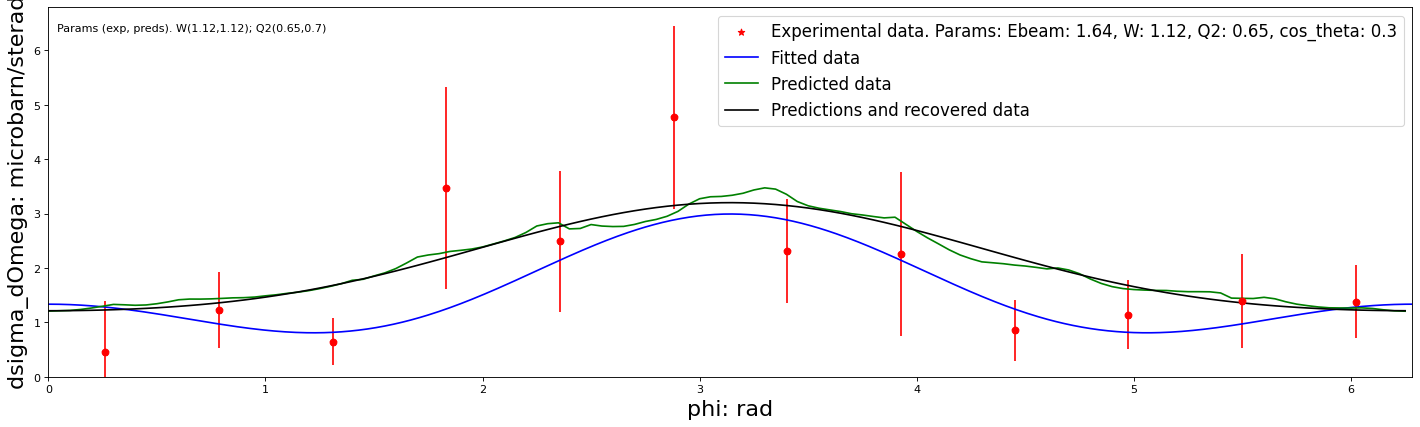

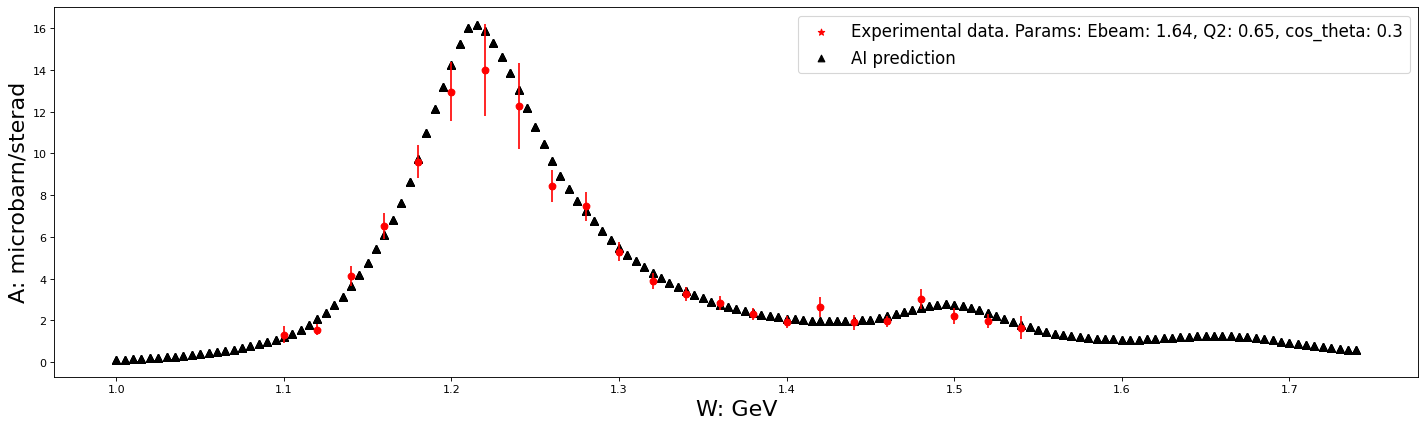

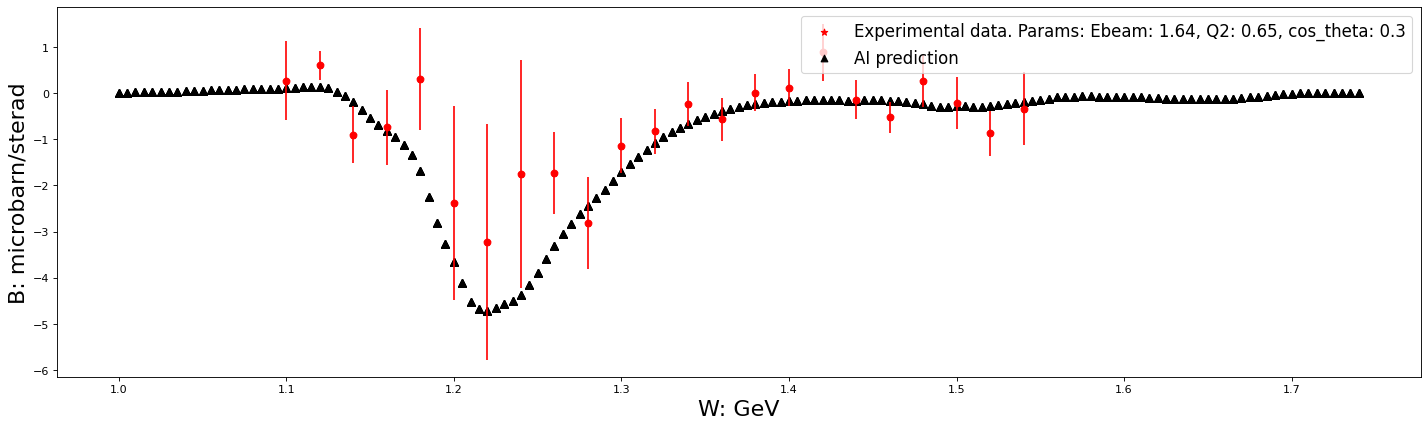

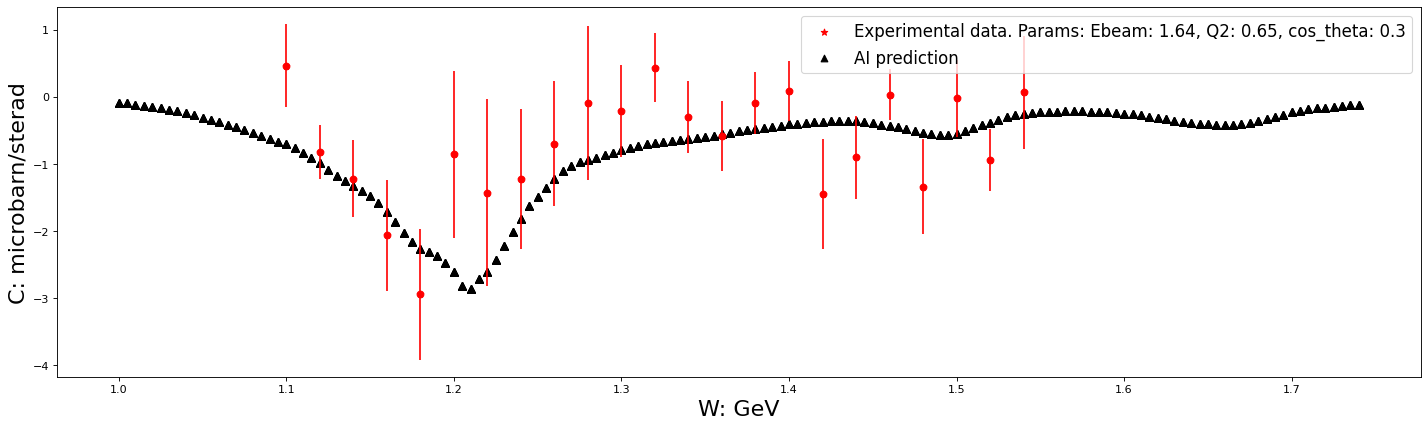

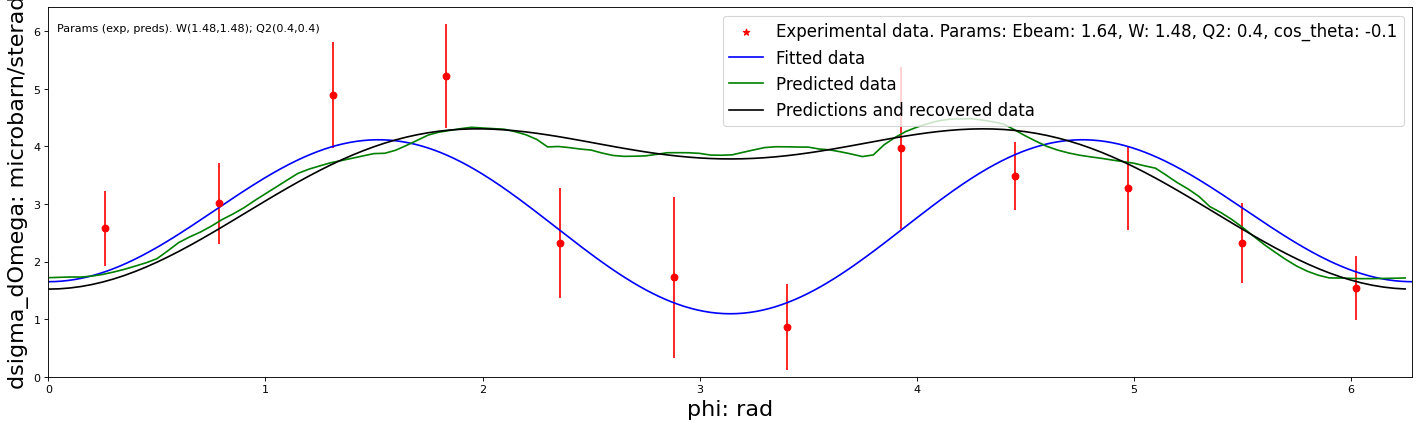

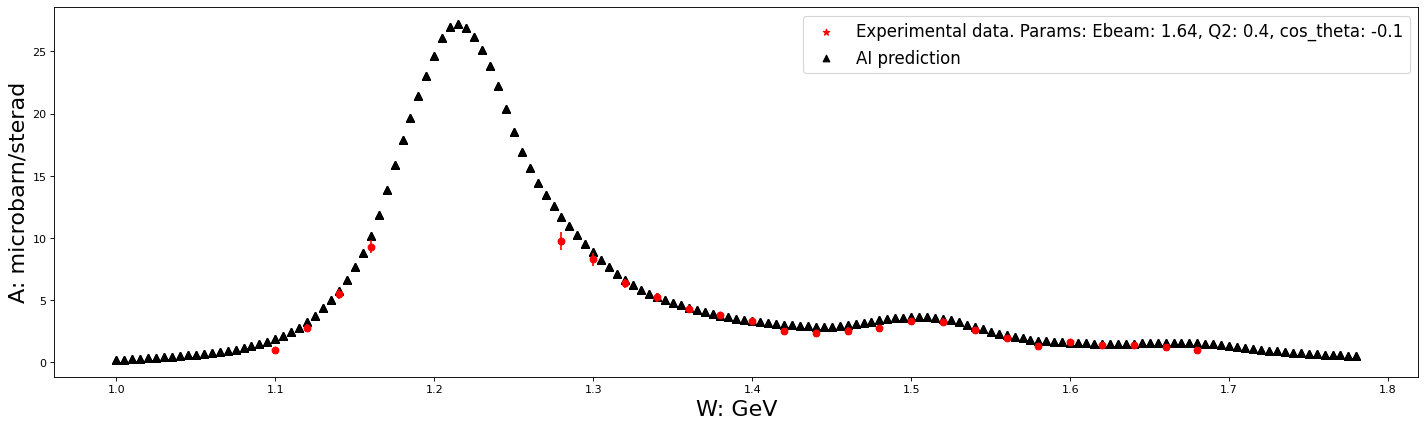

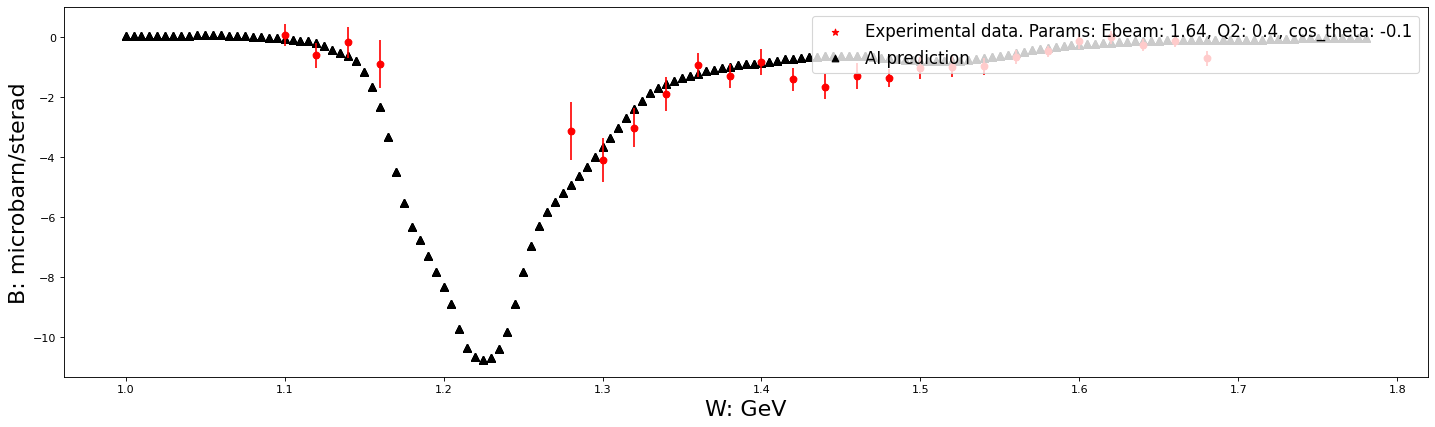

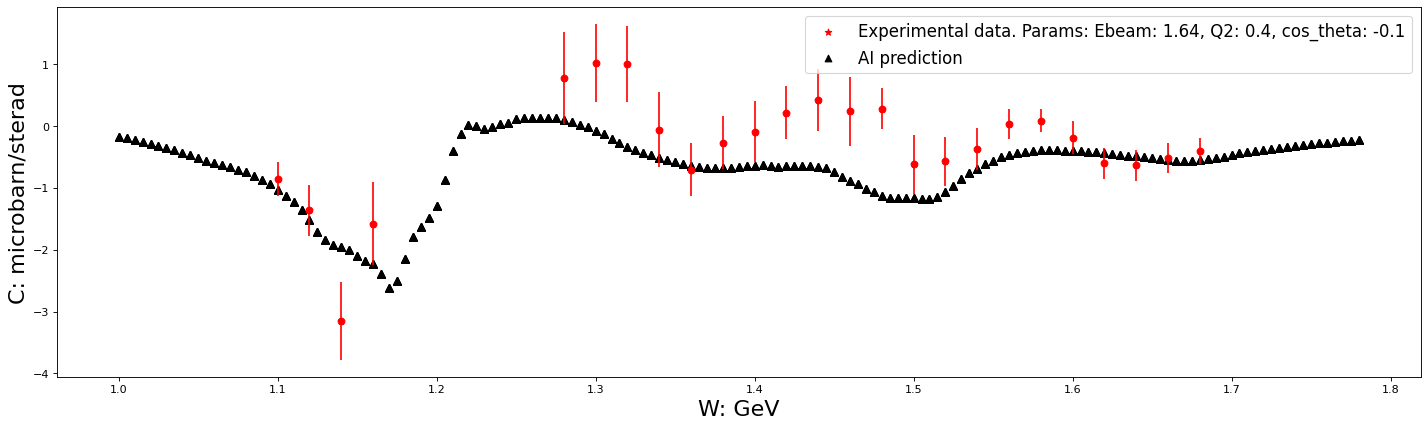

100%|██████████| 157/157 [00:07<00:00, 21.94it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-10-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.018124086017935203' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-10-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.013470242001037507' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

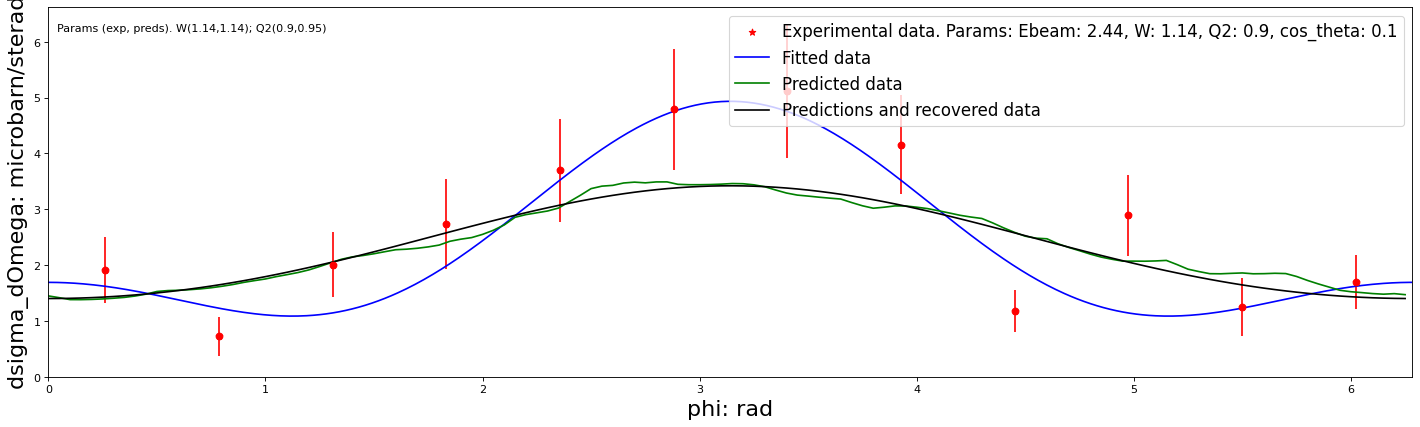

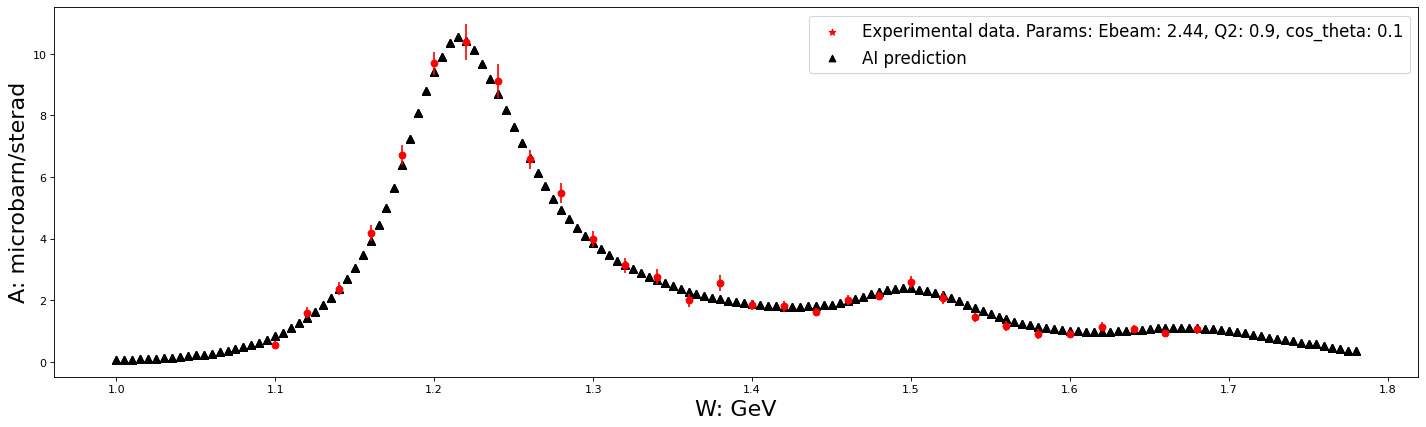

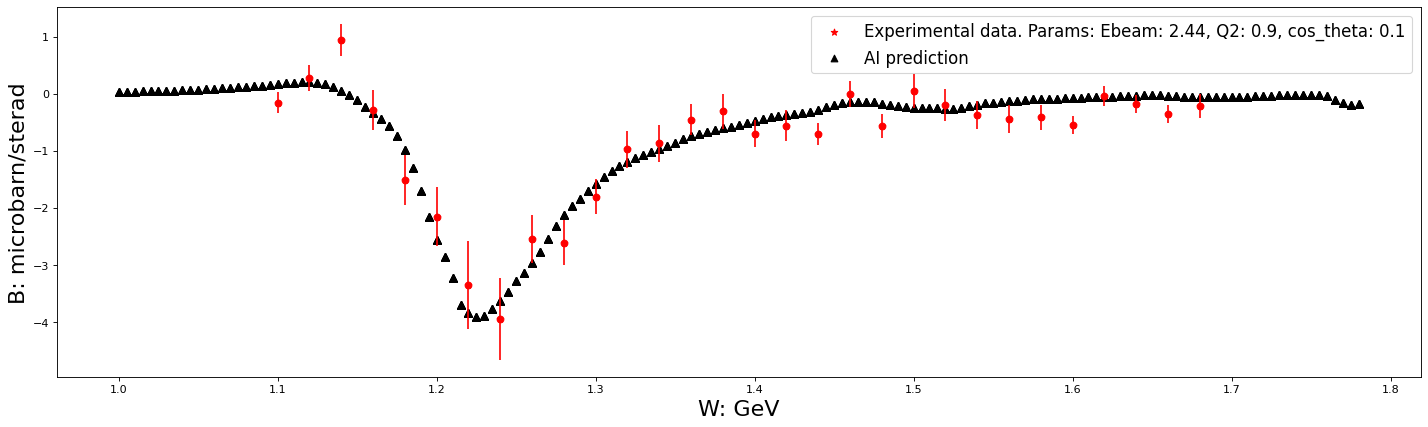

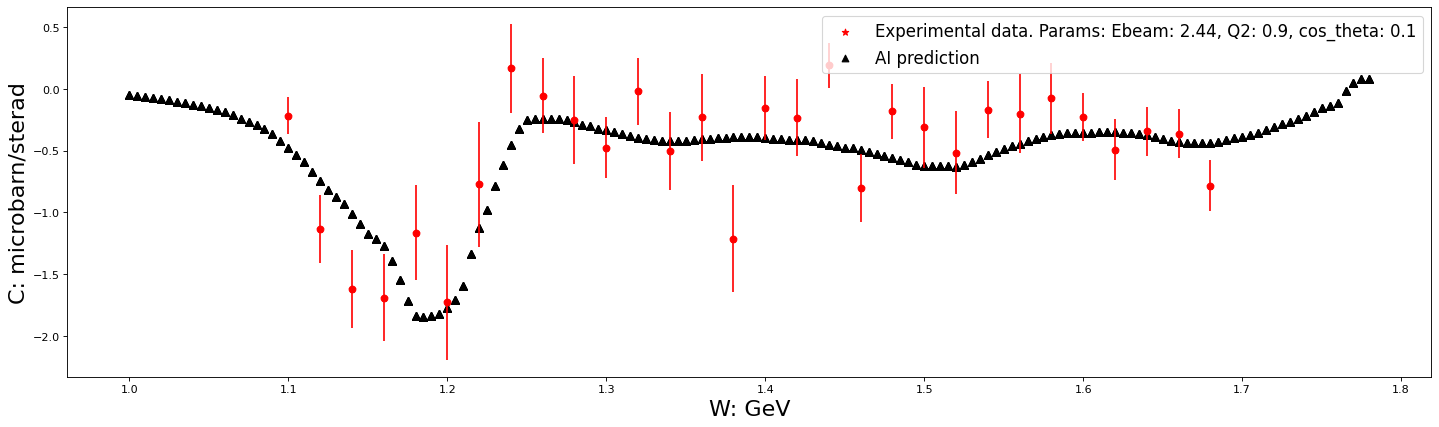

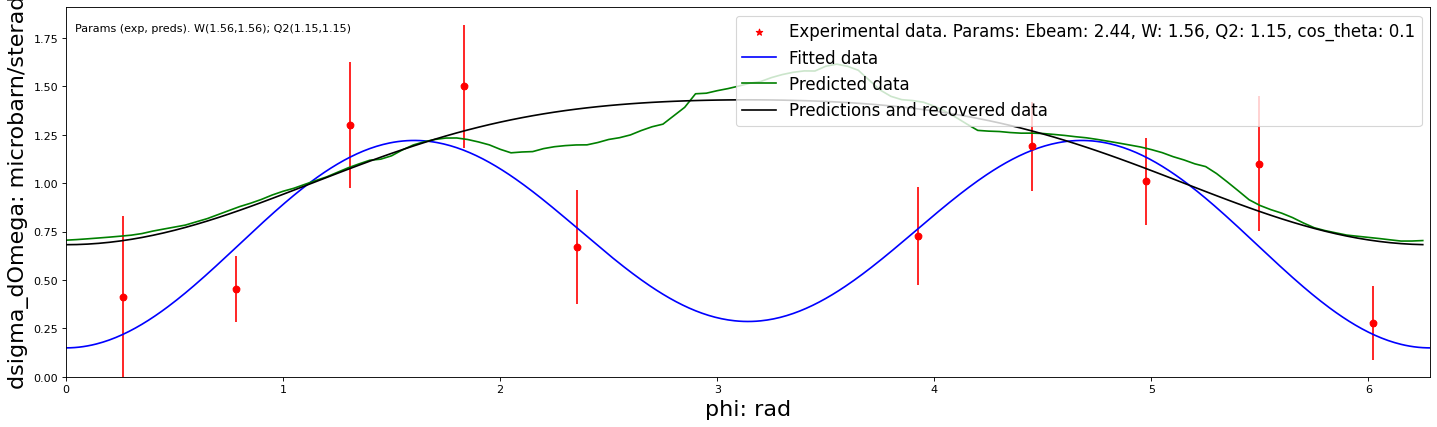

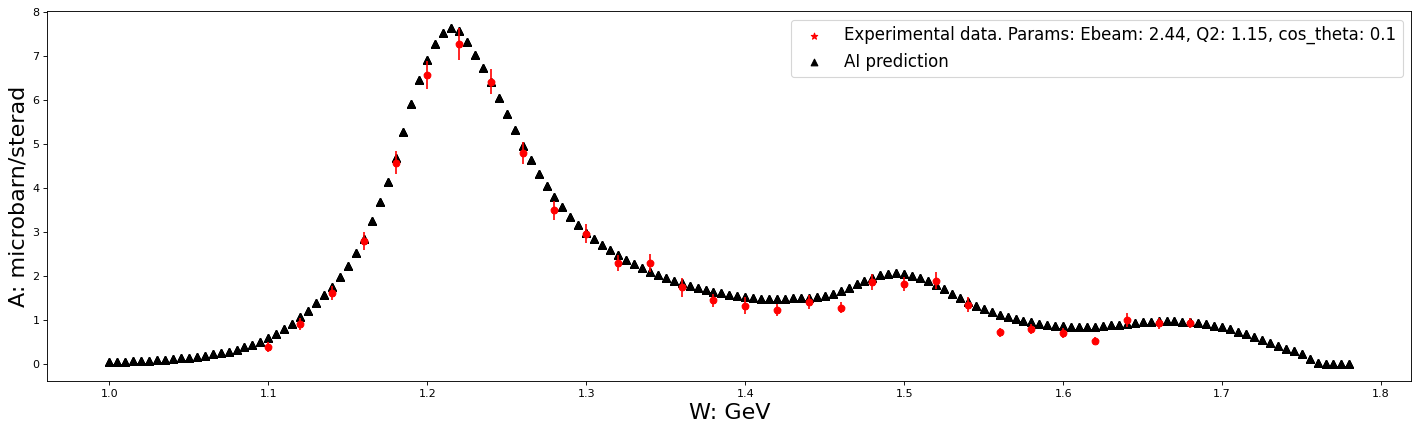

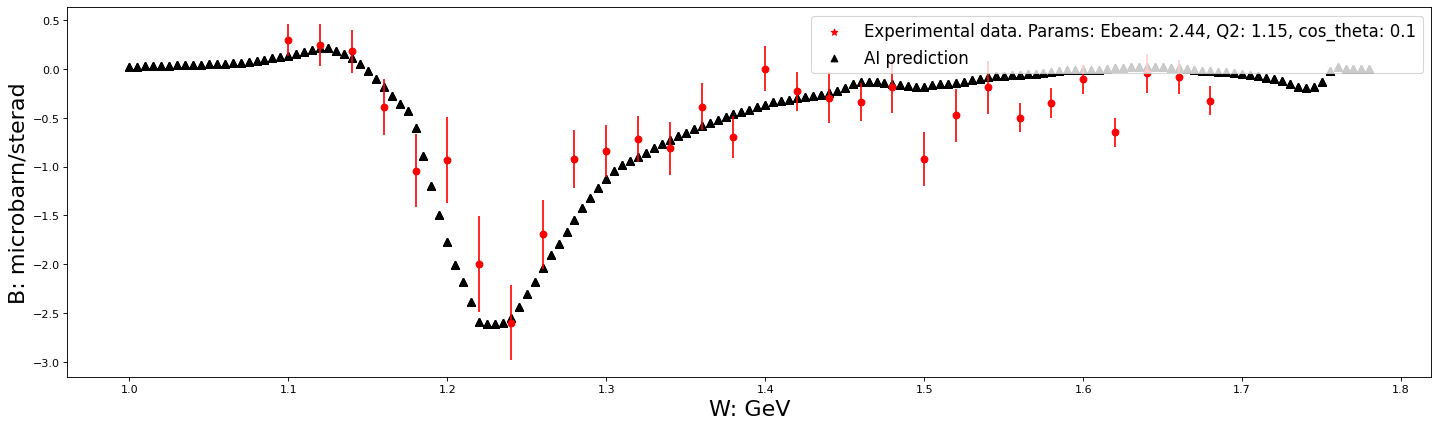

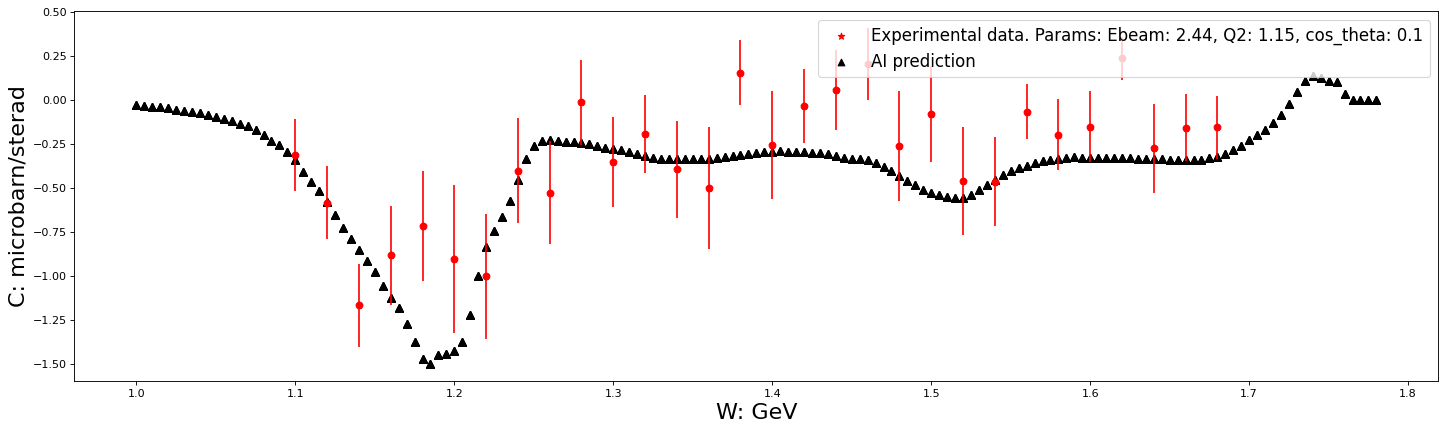

100%|██████████| 97/97 [00:08<00:00, 11.05it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-10-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.077142516698453e-07' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-10-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6177871776073205e-08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython

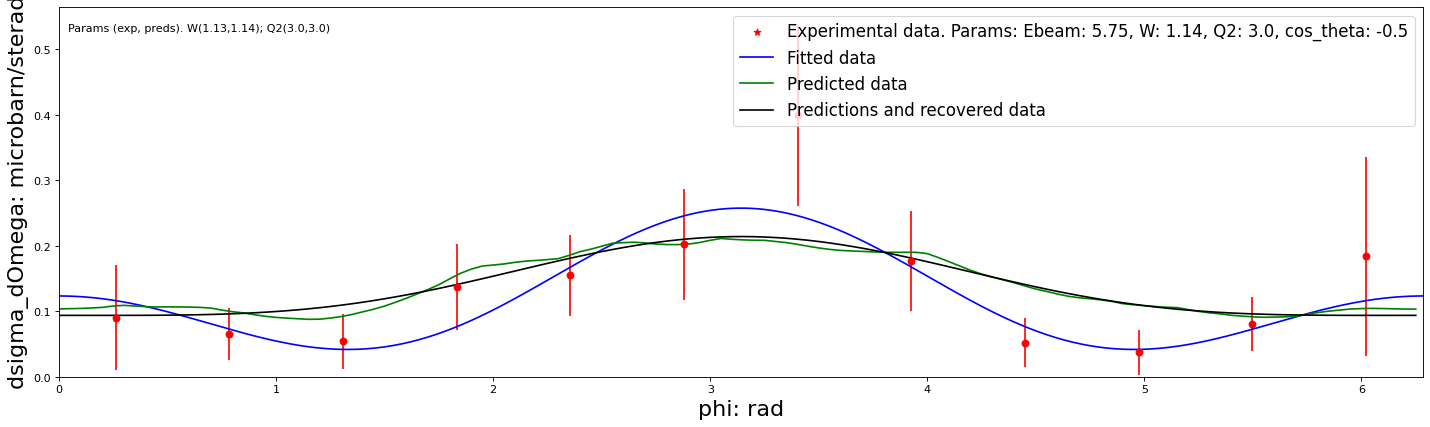

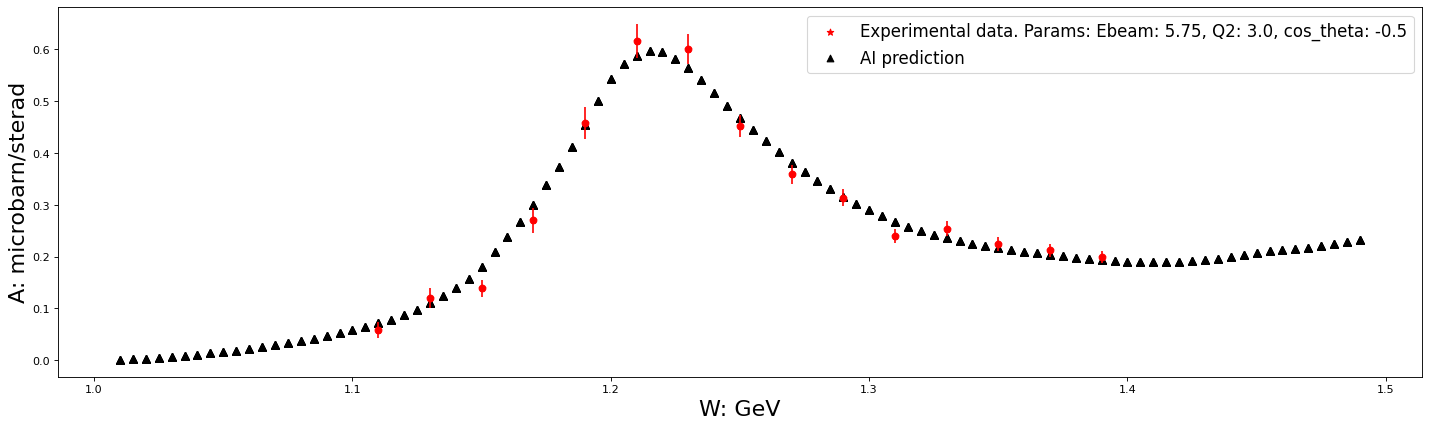

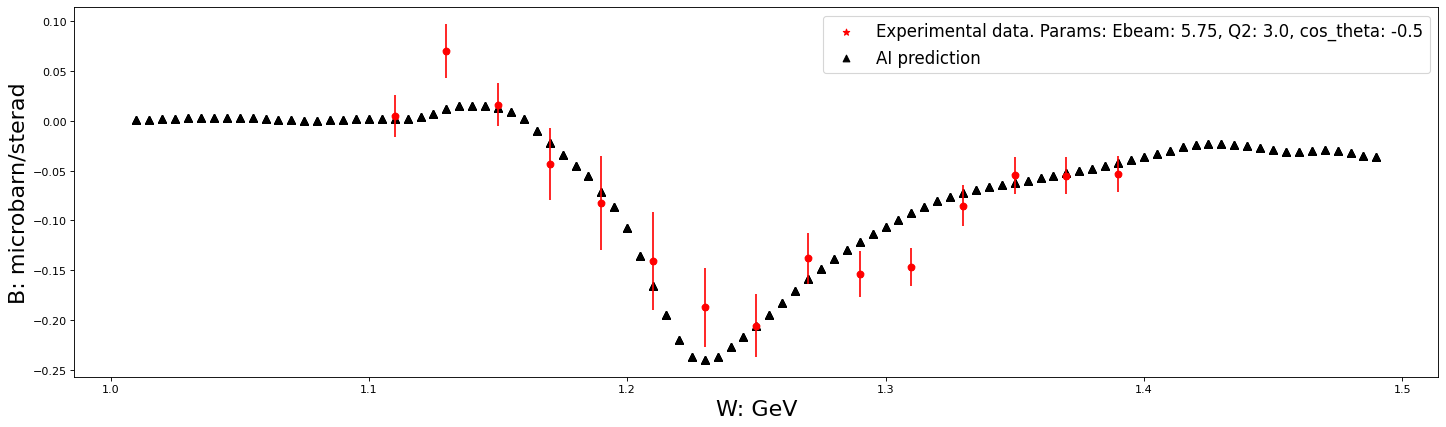

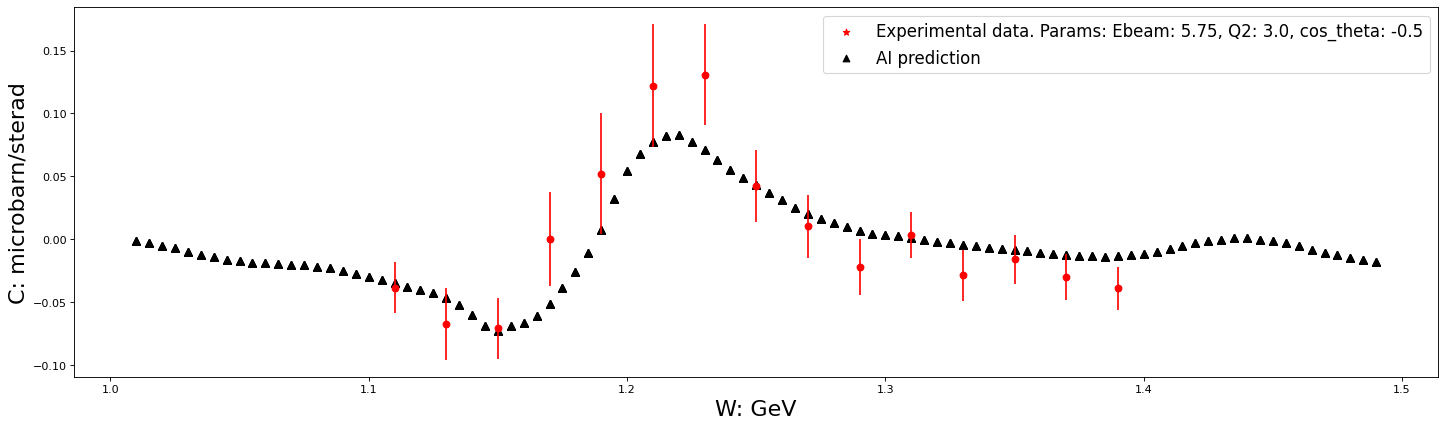

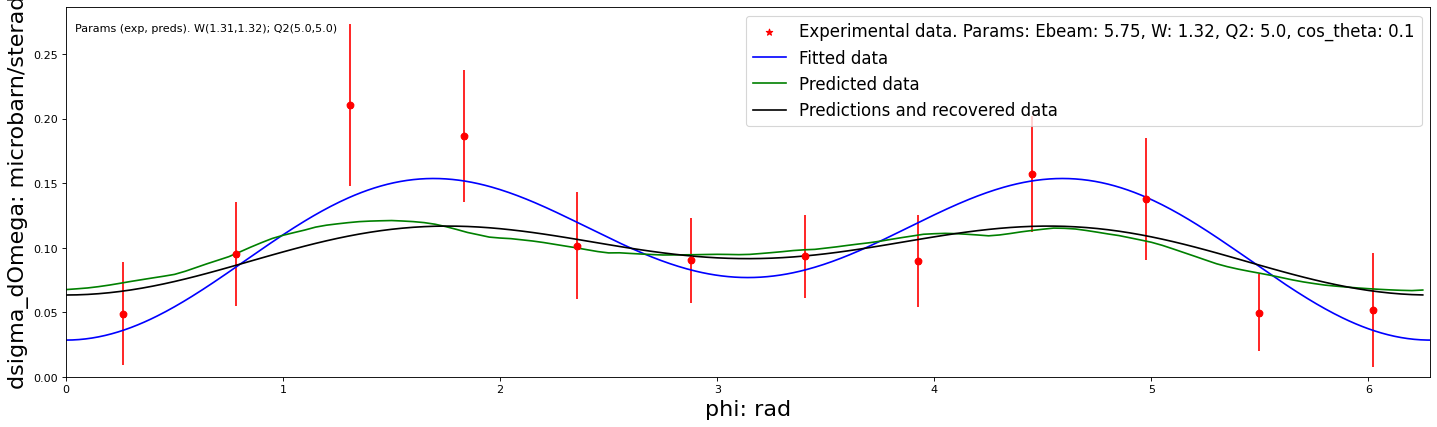

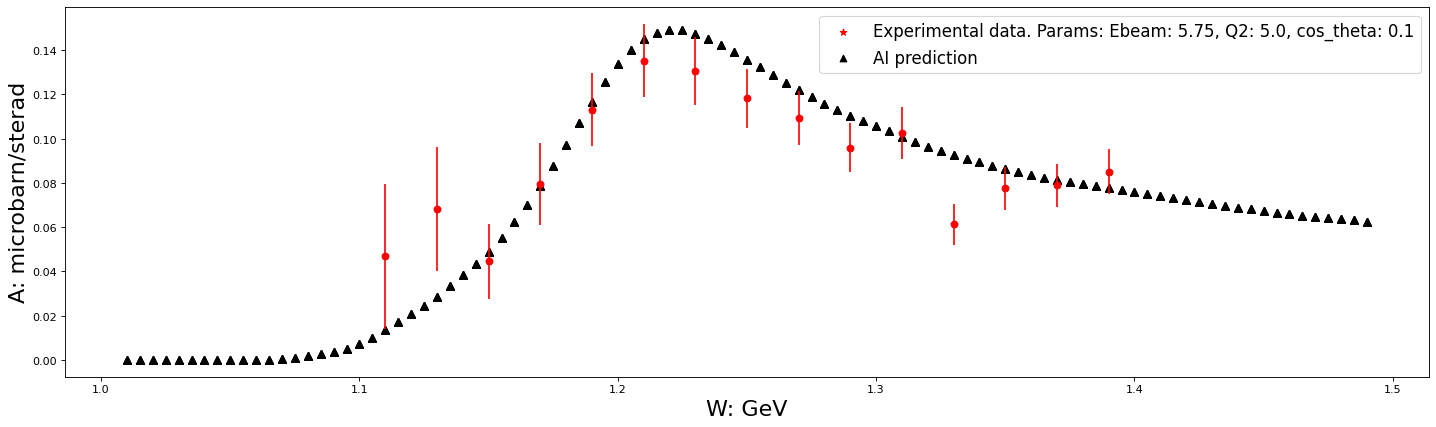

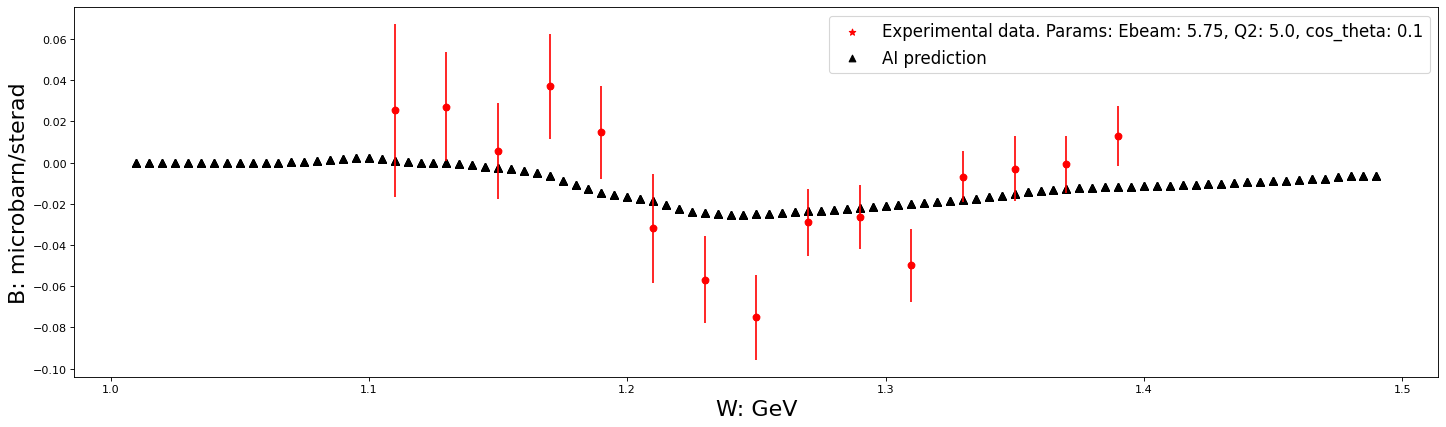

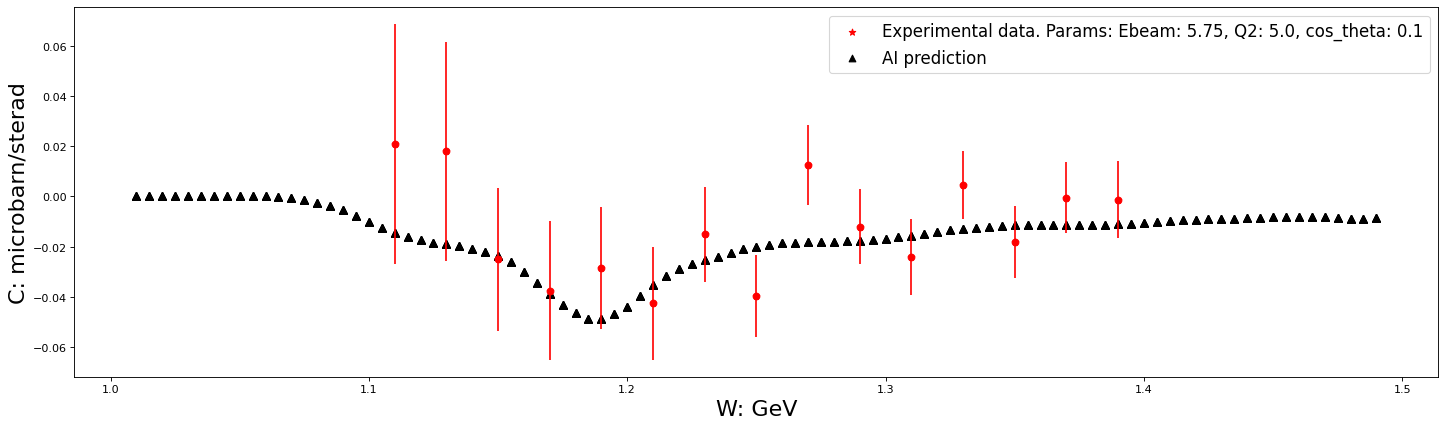

100%|██████████| 177/177 [00:05<00:00, 34.61it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-10-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09351881730658072' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-10-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.003163483208722509' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

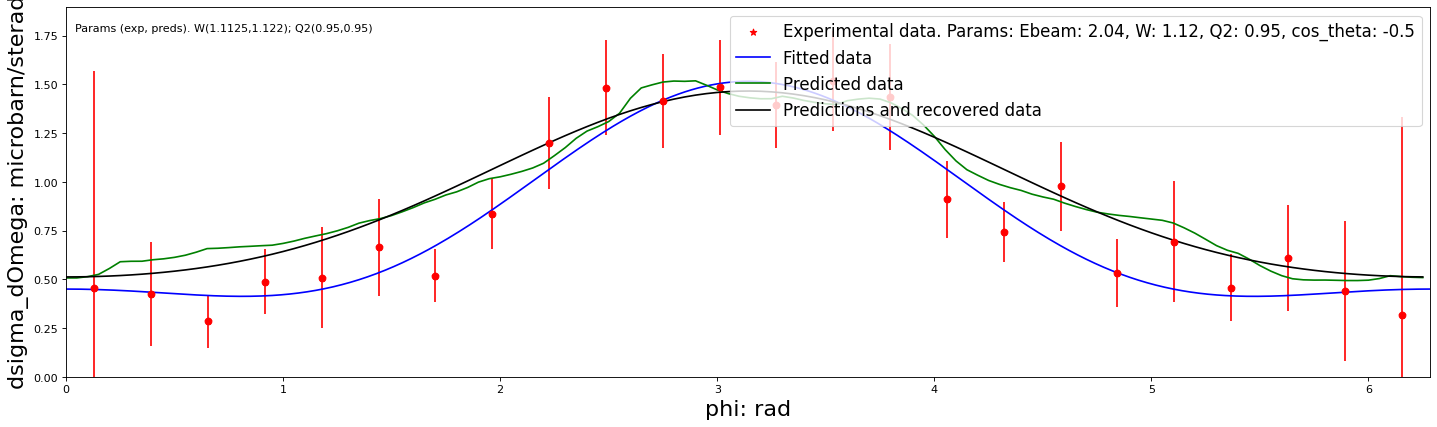

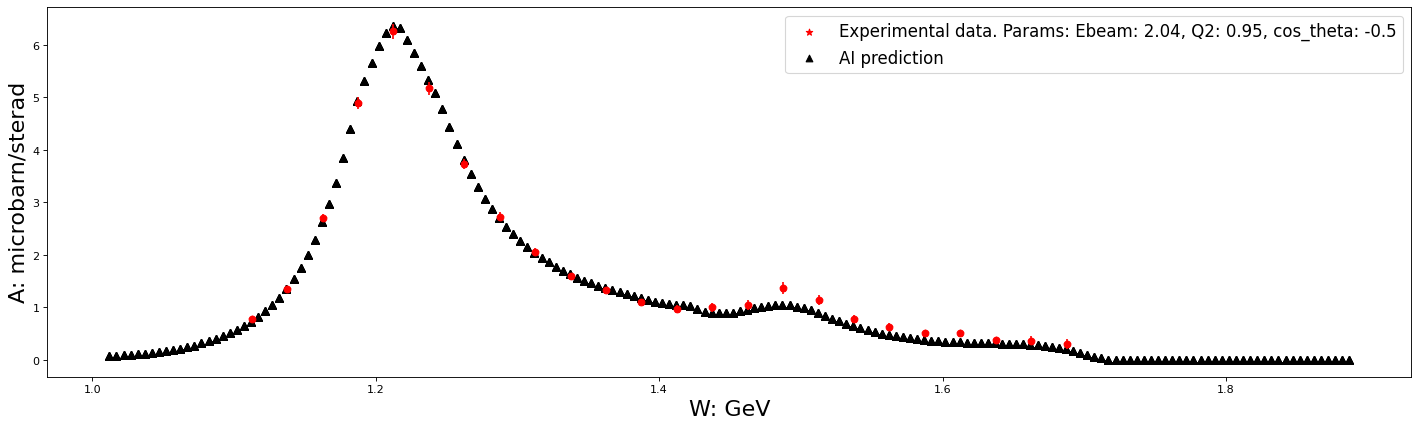

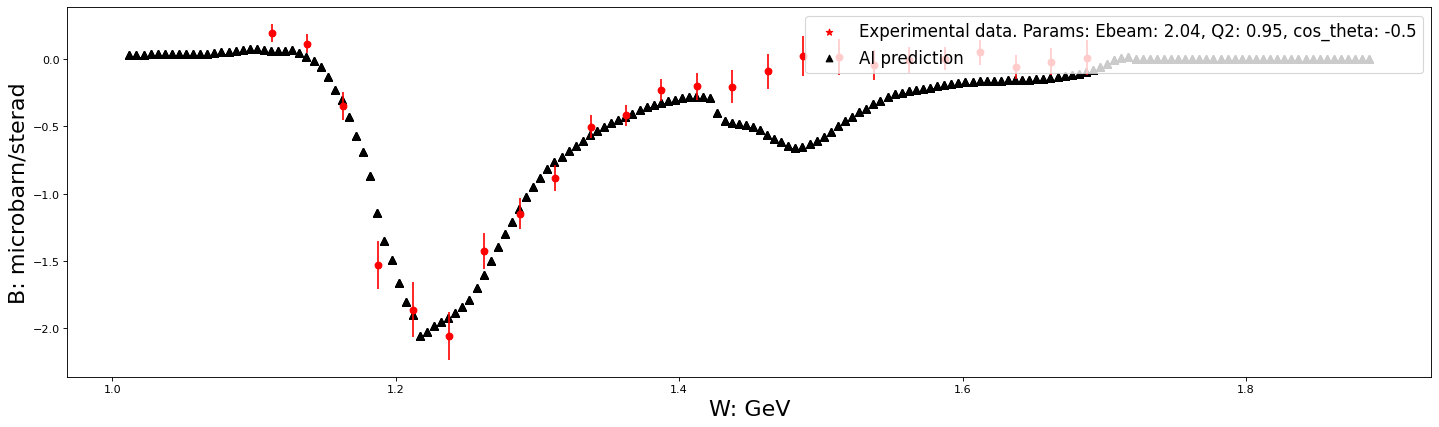

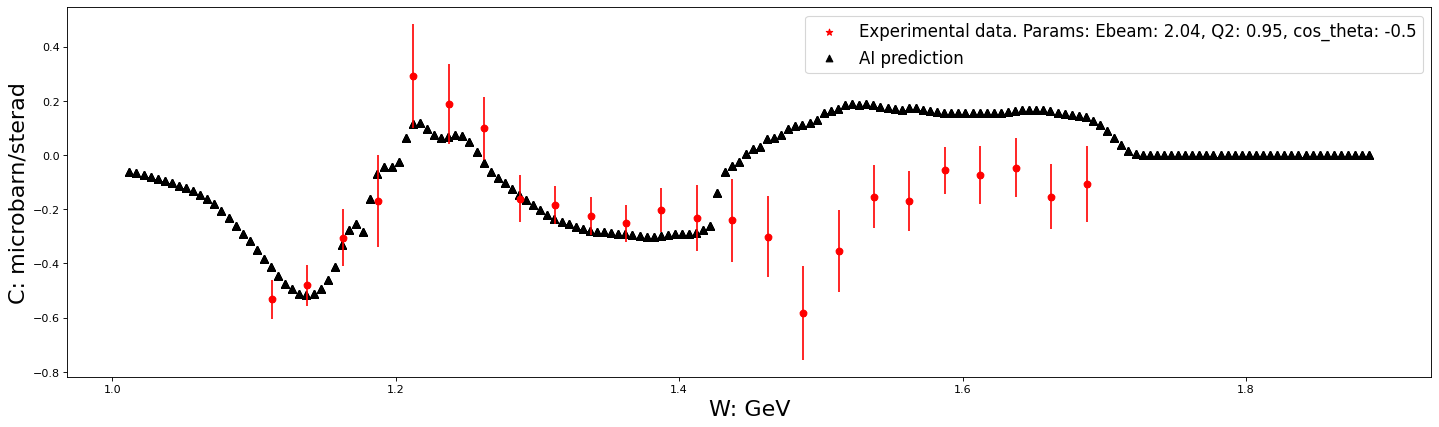

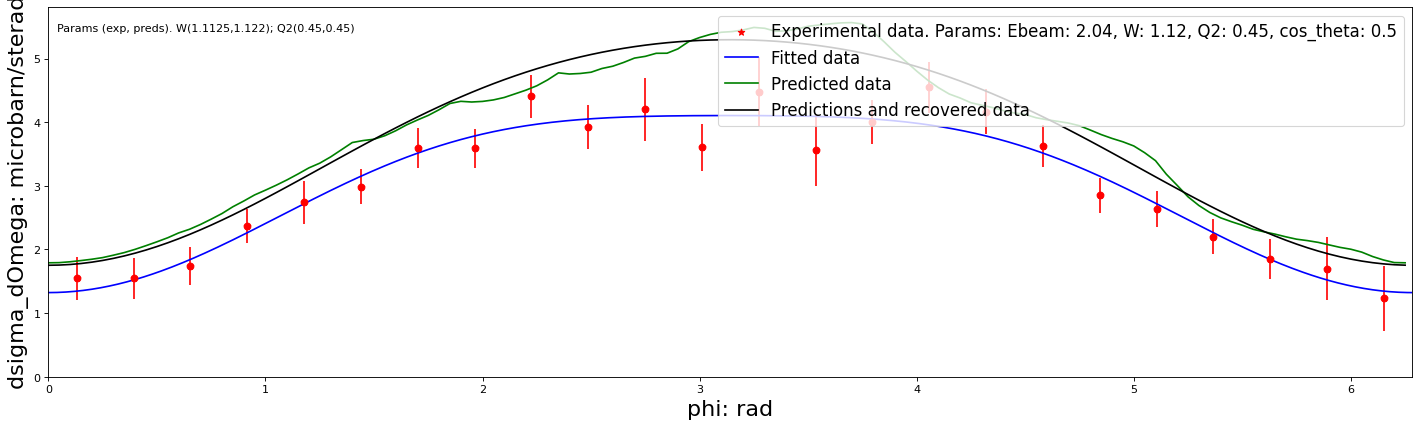

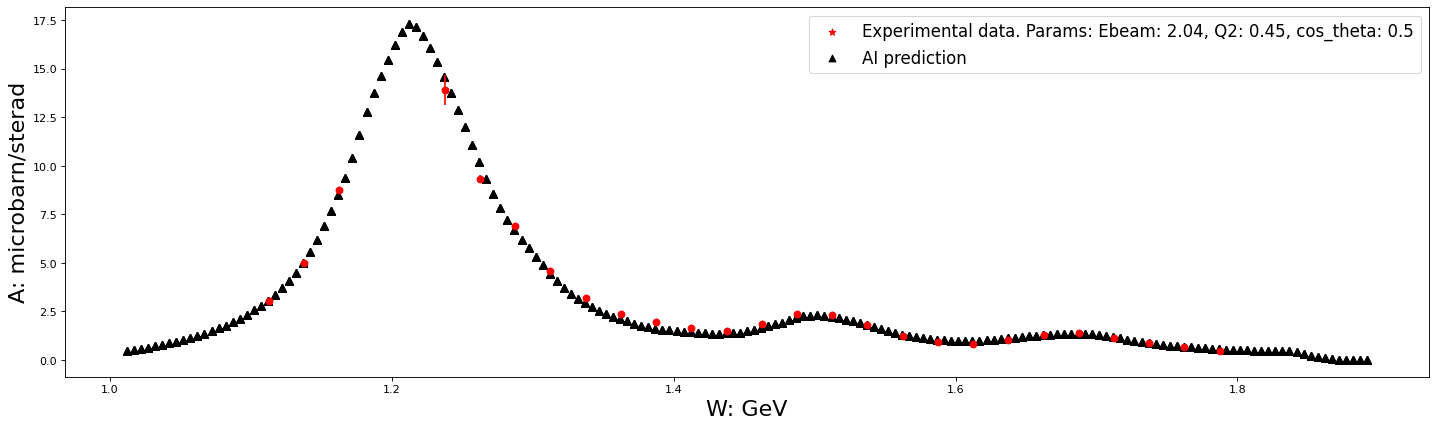

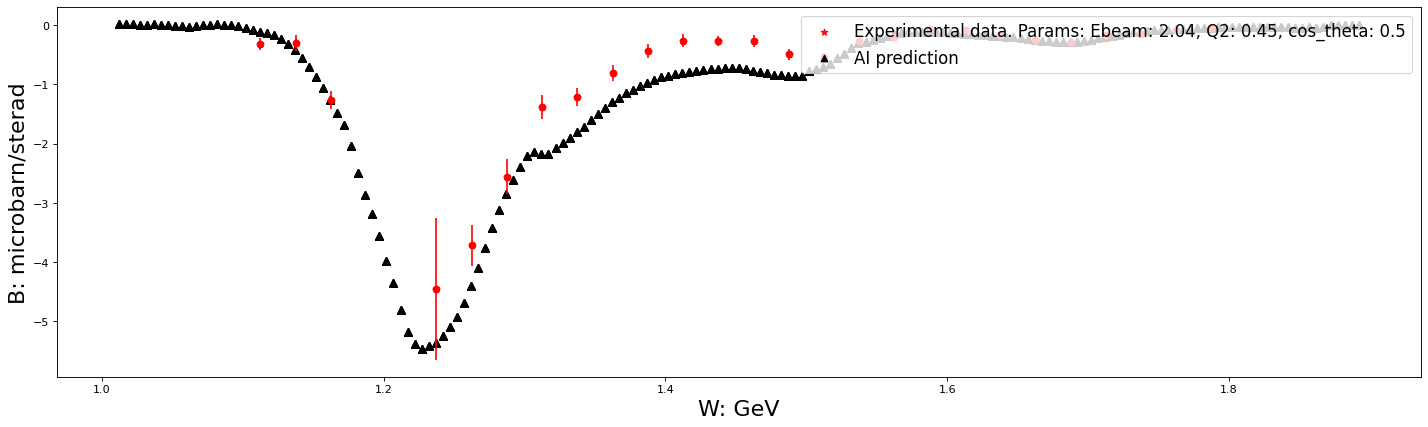

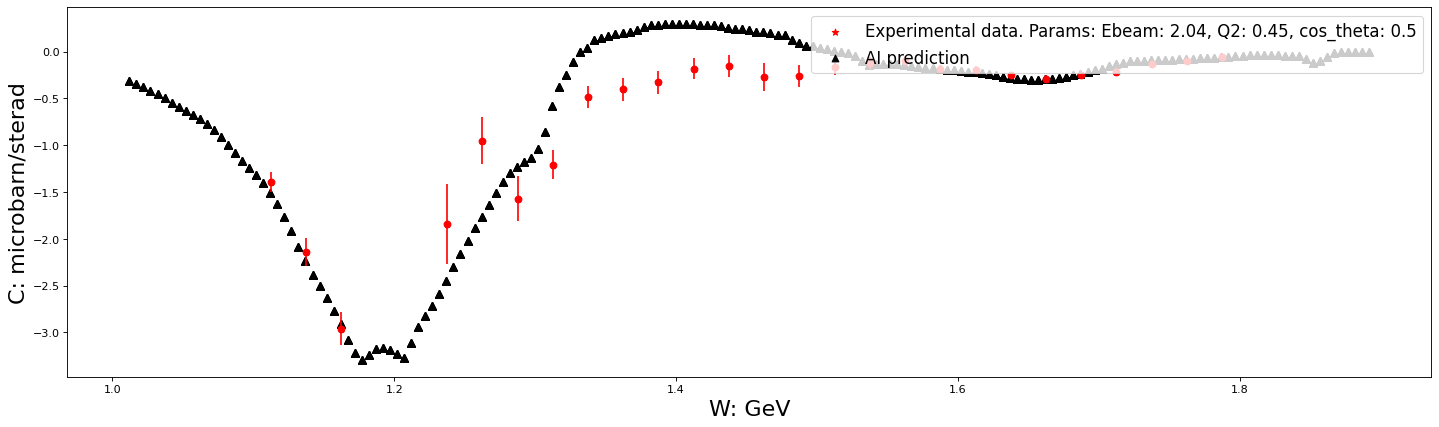

In [12]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [13]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2024-12-11 10:45:07,750 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 10:45:07,752 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 10:45:07,754 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 10:45:07,756 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 10:45:07,795 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2024-12-11 10:45:08,011 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-11 10:45:08,235 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-11 10:45:08,243 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 10:45:08,248 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 10:45:08,249 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 10:45:08,252 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 10:45:08,271 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 10:45:08,273 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 10:45:08,276 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 10:45:08,279 : DEBUG : STREAM b'IDAT' 131 38167
2024-12-11 10:45:08,302 : DEBUG : STREAM b'IHDR' 16 13
202

In [14]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2024-12-11 10:45:10,900 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 10:45:10,903 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 10:45:10,908 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 10:45:10,911 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 10:45:10,939 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 10:45:10,946 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 10:45:10,950 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 10:45:10,952 : DEBUG : STREAM b'IDAT' 131 38167
2024-12-11 10:45:10,973 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 10:45:10,976 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 10:45:10,979 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 10:45:10,983 : DEBUG : STREAM b'IDAT' 131 36430
2024-12-11 10:45:11,009 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 10:45:11,016 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 10:45:11,018 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 10:45:11,024 : DEBUG : STREAM b'IDAT' 131 36963
2024-12-11 10:45:11,051 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 10:45:11,056 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [15]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,███▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇█████████████████████████████████████
train_rmse,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▂▁▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▄▃▂▁▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▃▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 157/157 [00:04<00:00, 33.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3846924947271446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006029384299421474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input

2024-12-03 16:02:50,100 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-03 16:02:50,103 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-03 16:02:50,106 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-12-03 16:02:50,109 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-03 16:02:50,111 : DEBUG : findfont: sc

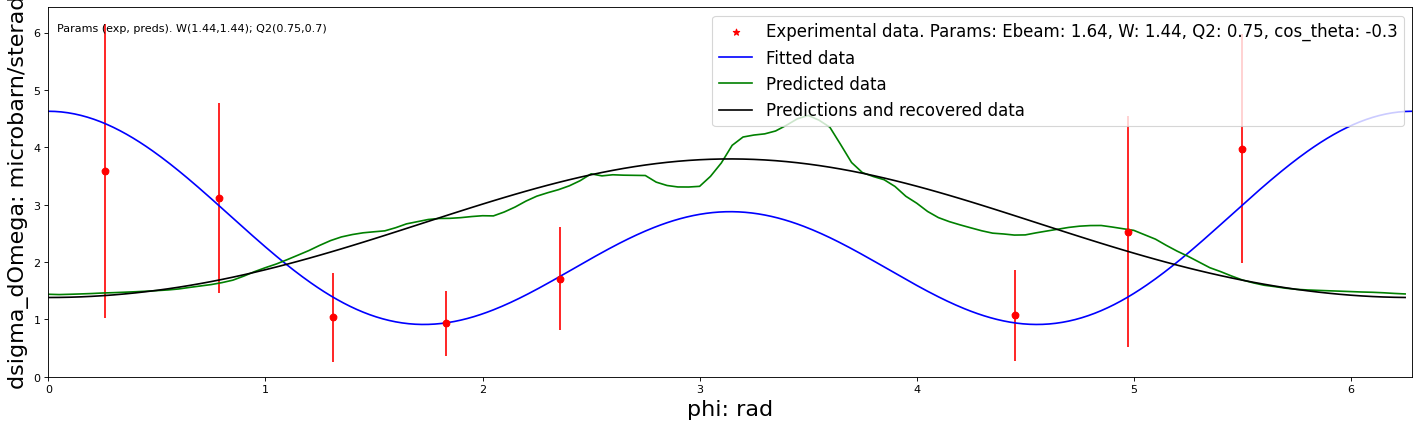

2024-12-03 16:02:52,649 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,651 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:52,653 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:52,655 : DEBUG : STREAM b'IDAT' 131 36433
2024-12-03 16:02:52,787 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,790 : DEBUG : STREAM b'IDAT' 41 36433


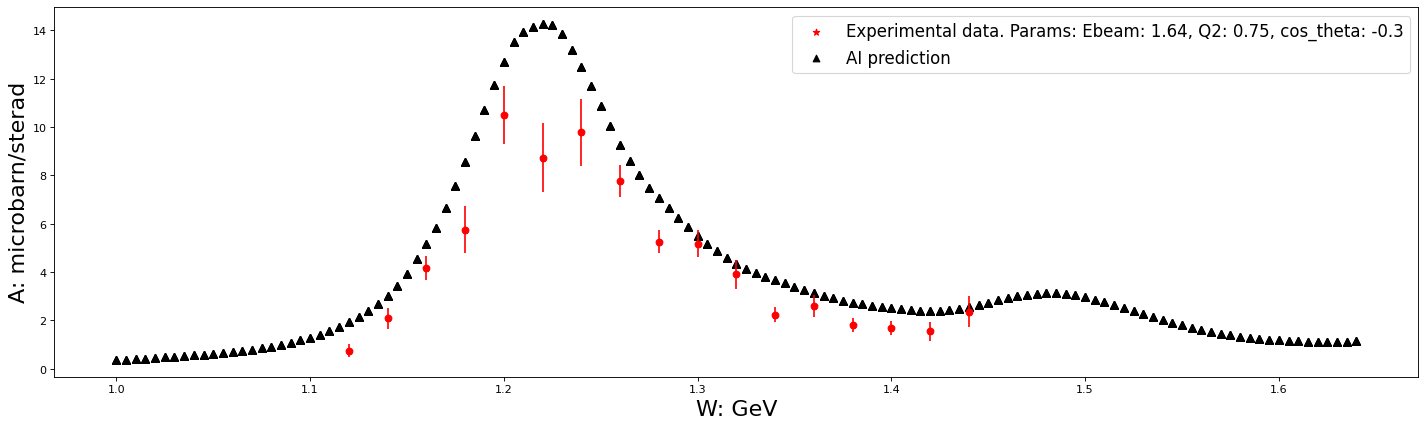

2024-12-03 16:02:53,850 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,852 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:53,854 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:53,856 : DEBUG : STREAM b'IDAT' 131 35982
2024-12-03 16:02:53,938 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,940 : DEBUG : STREAM b'IDAT' 41 35982


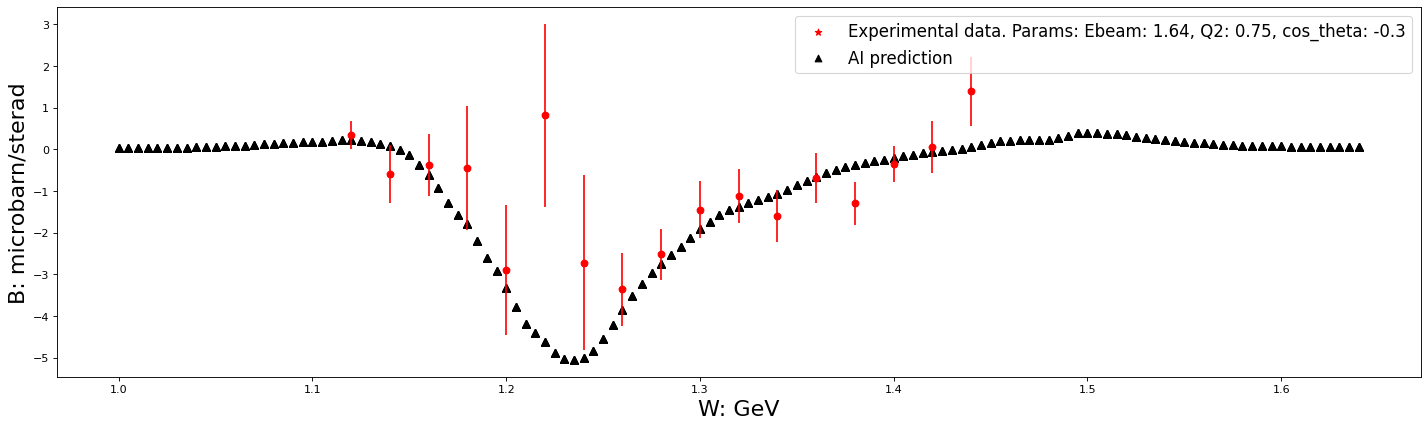

2024-12-03 16:02:54,613 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,615 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:54,617 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:54,620 : DEBUG : STREAM b'IDAT' 131 36865
2024-12-03 16:02:54,704 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,706 : DEBUG : STREAM b'IDAT' 41 36865


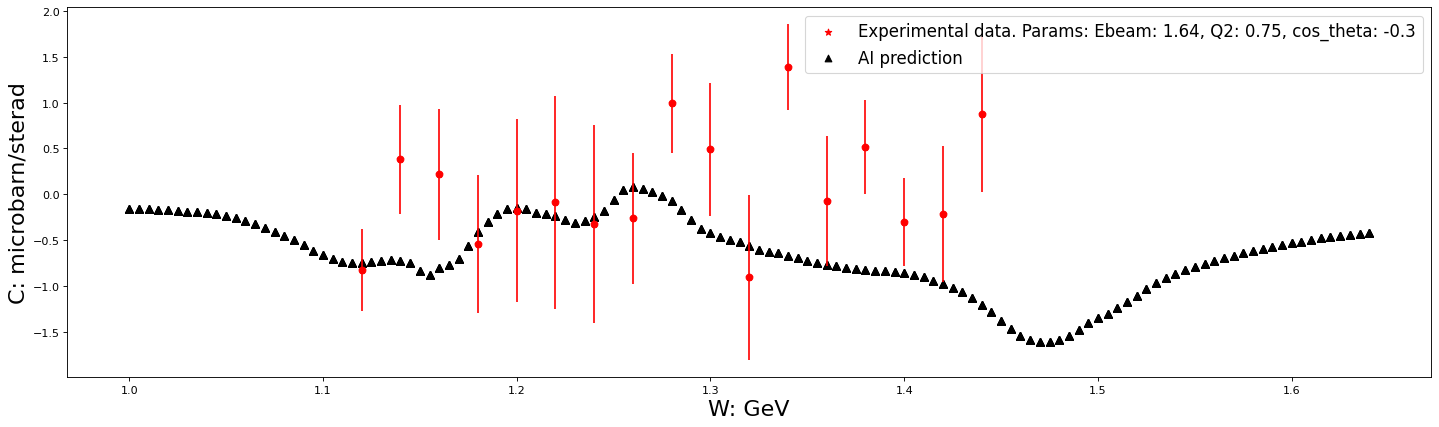

1
2024-12-03 16:02:55,385 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,387 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:55,390 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:55,394 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:02:55,485 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,488 : DEBUG : STREAM b'IDAT' 41 65536


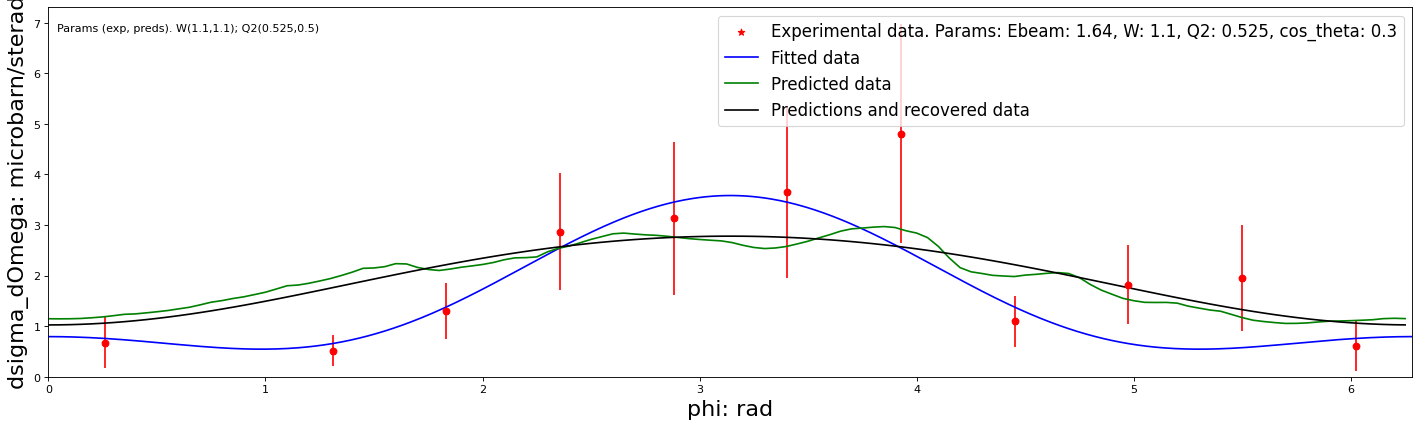

2024-12-03 16:02:56,183 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,185 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:56,191 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:56,195 : DEBUG : STREAM b'IDAT' 131 37516
2024-12-03 16:02:56,292 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,295 : DEBUG : STREAM b'IDAT' 41 37516


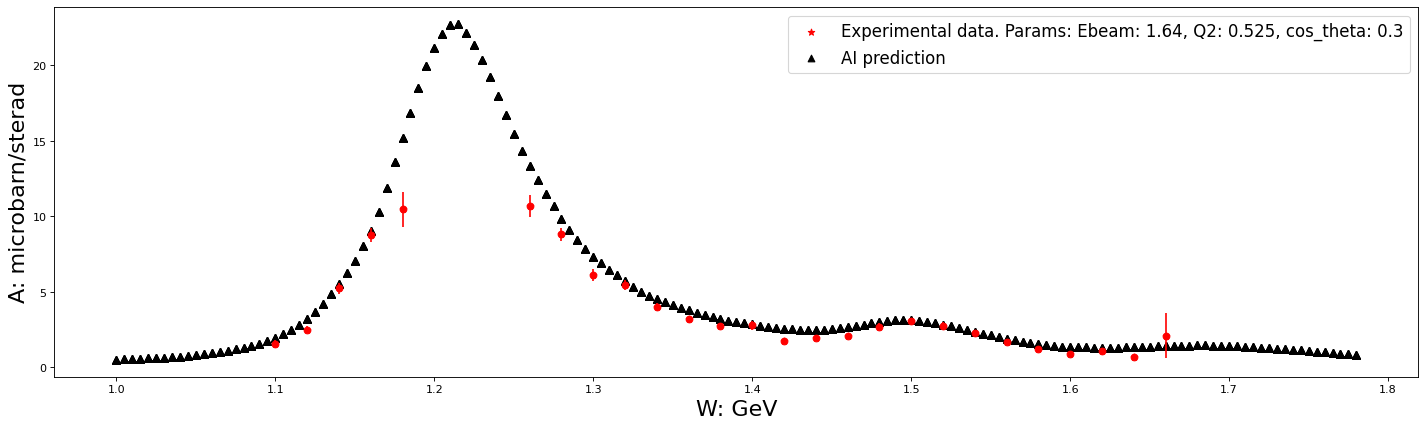

2024-12-03 16:02:56,996 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,998 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,000 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,002 : DEBUG : STREAM b'IDAT' 131 36214
2024-12-03 16:02:57,084 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,086 : DEBUG : STREAM b'IDAT' 41 36214


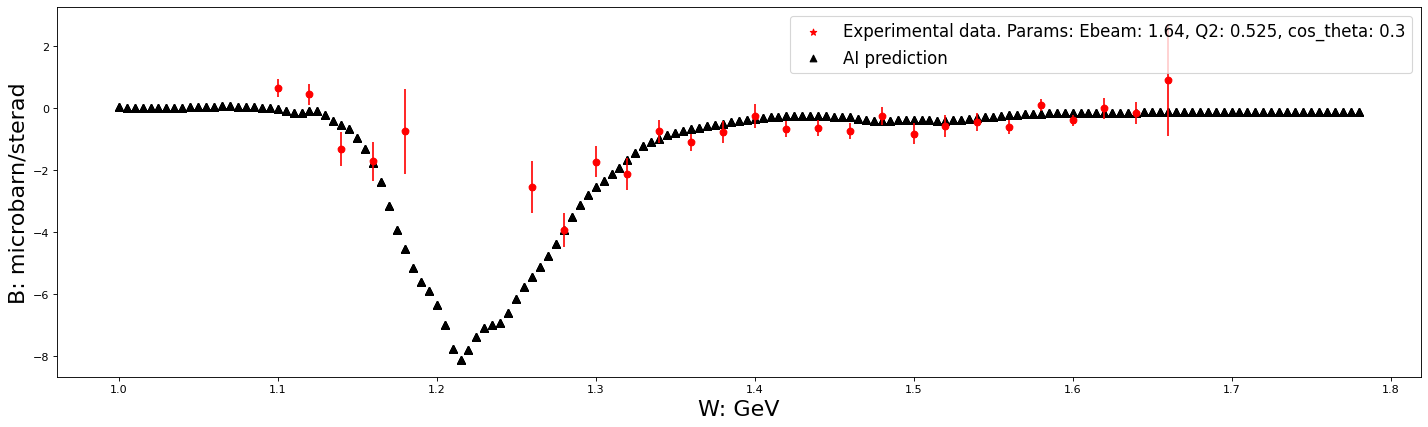

2024-12-03 16:02:57,790 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,792 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,795 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,798 : DEBUG : STREAM b'IDAT' 131 36991
2024-12-03 16:02:57,884 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,886 : DEBUG : STREAM b'IDAT' 41 36991


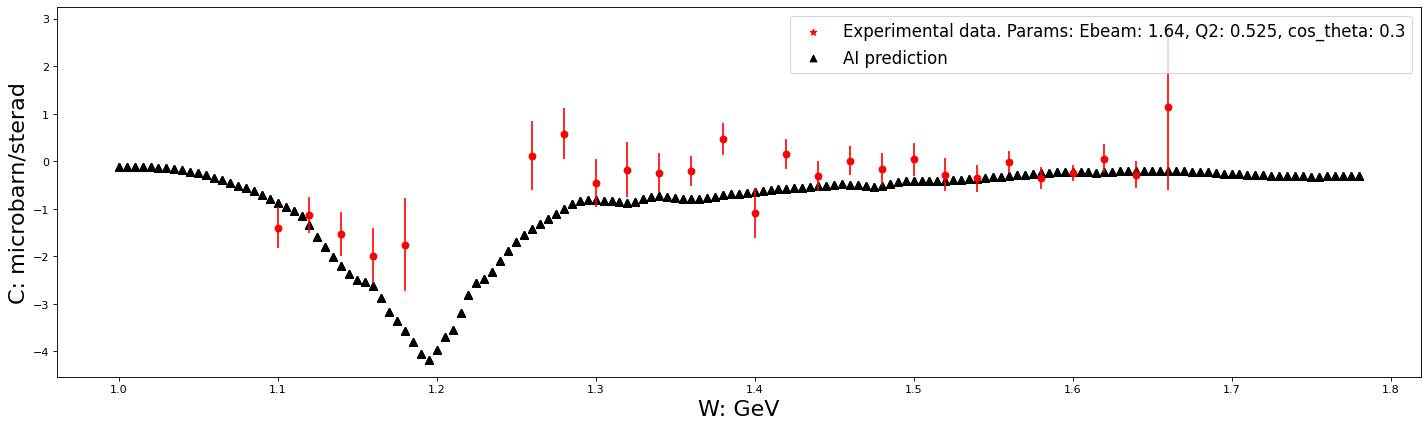

2


100%|██████████| 157/157 [00:07<00:00, 21.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3759944385466103' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06444017856602151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-

2024-12-03 16:17:39,521 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,522 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:39,525 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:39,528 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:39,644 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,647 : DEBUG : STREAM b'IDAT' 41 65536


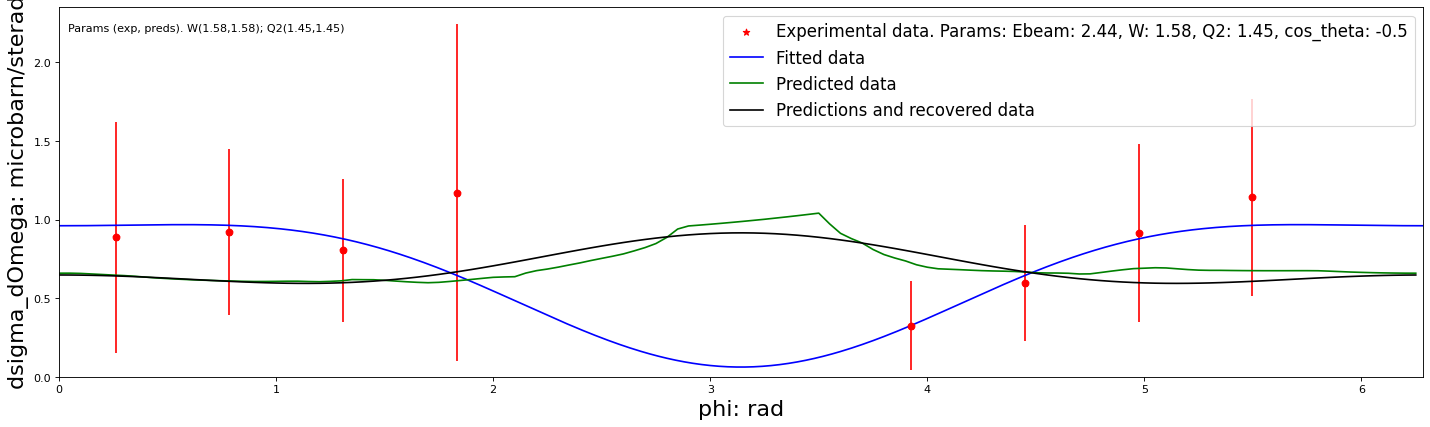

2024-12-03 16:17:40,530 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,533 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:40,535 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:40,537 : DEBUG : STREAM b'IDAT' 131 39649
2024-12-03 16:17:40,633 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,636 : DEBUG : STREAM b'IDAT' 41 39649


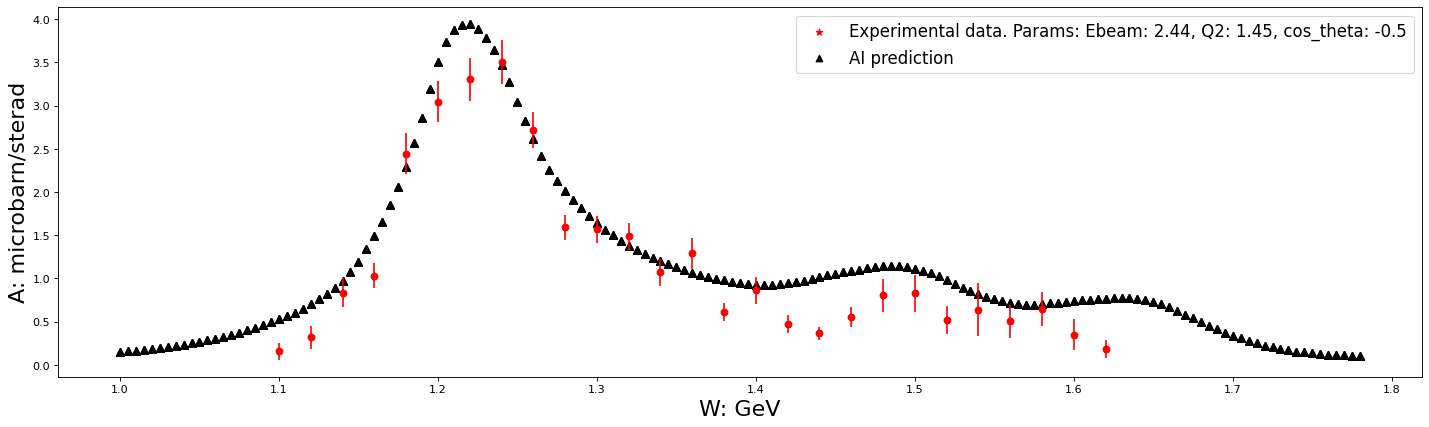

2024-12-03 16:17:41,532 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,534 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:41,537 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:41,539 : DEBUG : STREAM b'IDAT' 131 39774
2024-12-03 16:17:41,635 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,641 : DEBUG : STREAM b'IDAT' 41 39774


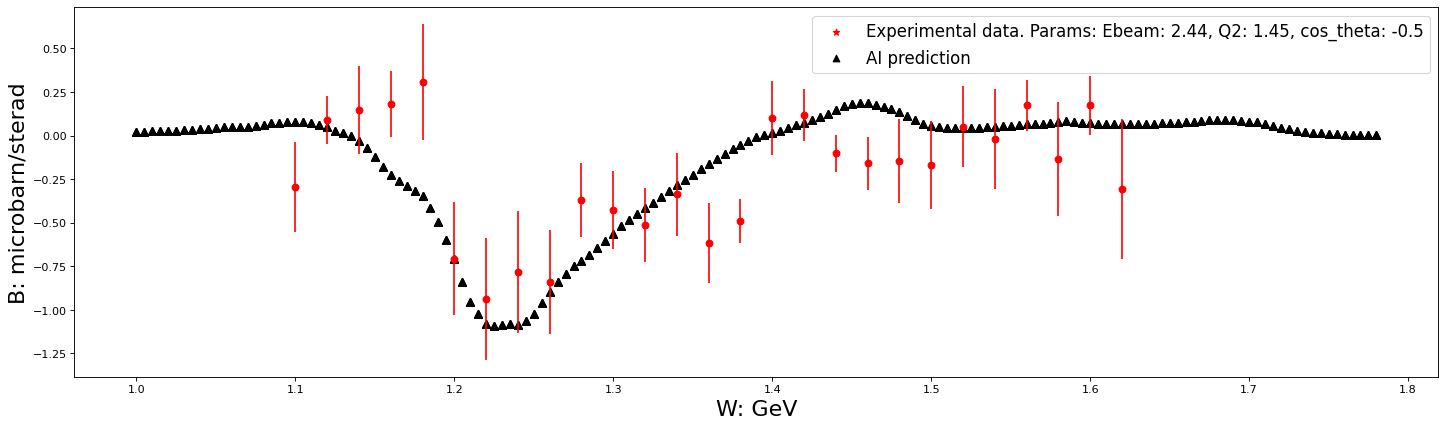

2024-12-03 16:17:42,570 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,574 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:42,576 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:42,579 : DEBUG : STREAM b'IDAT' 131 40327
2024-12-03 16:17:42,675 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,677 : DEBUG : STREAM b'IDAT' 41 40327


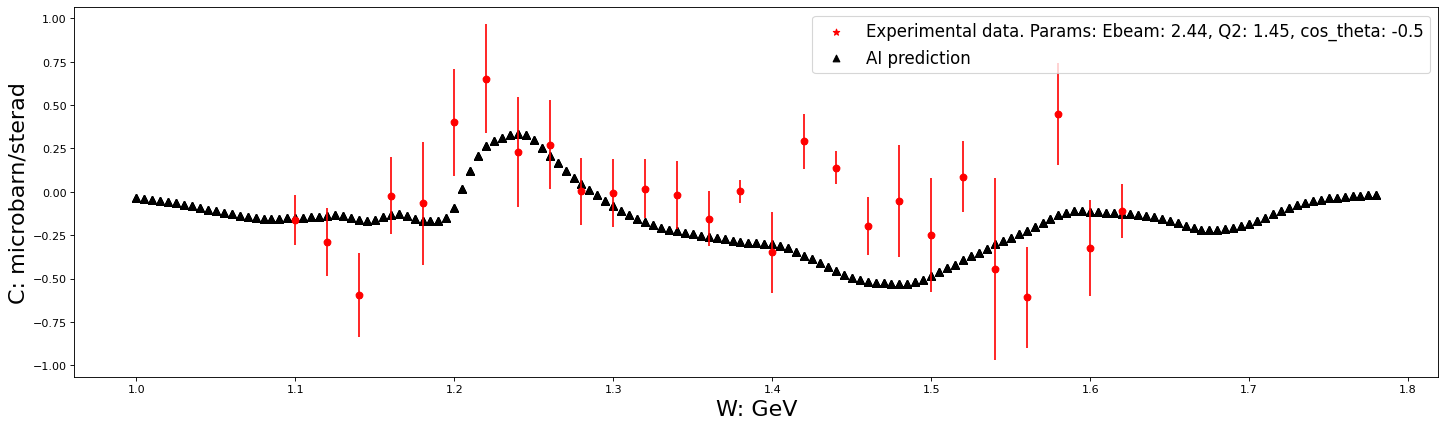

1
2024-12-03 16:17:43,580 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,582 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:43,585 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:43,588 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:43,687 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,692 : DEBUG : STREAM b'IDAT' 41 65536


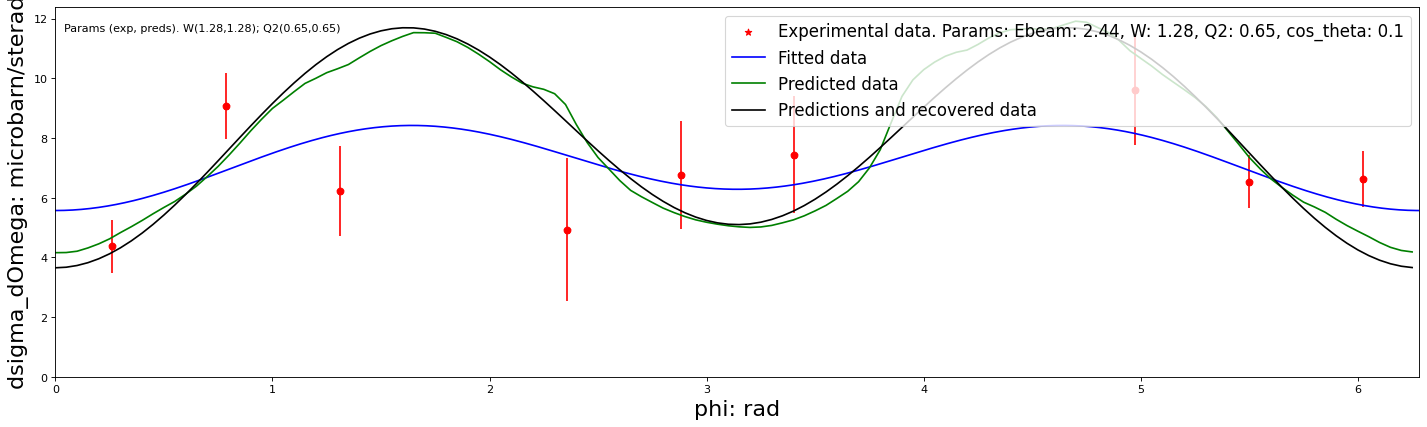

2024-12-03 16:17:44,586 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,589 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:44,591 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:44,594 : DEBUG : STREAM b'IDAT' 131 39500
2024-12-03 16:17:44,691 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,693 : DEBUG : STREAM b'IDAT' 41 39500


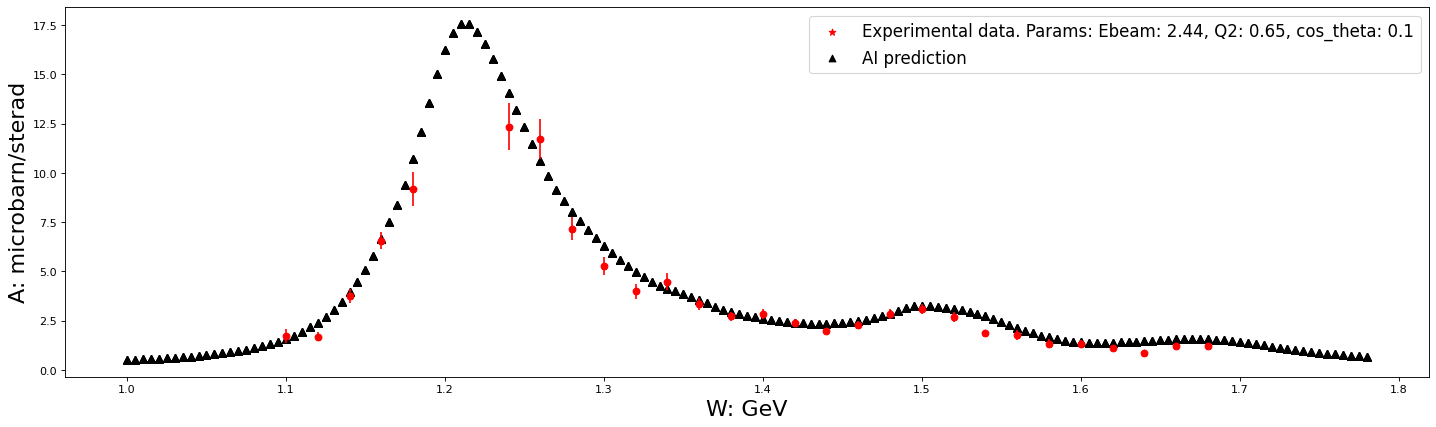

2024-12-03 16:17:45,591 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,593 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:45,596 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:45,599 : DEBUG : STREAM b'IDAT' 131 36530
2024-12-03 16:17:45,692 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,694 : DEBUG : STREAM b'IDAT' 41 36530


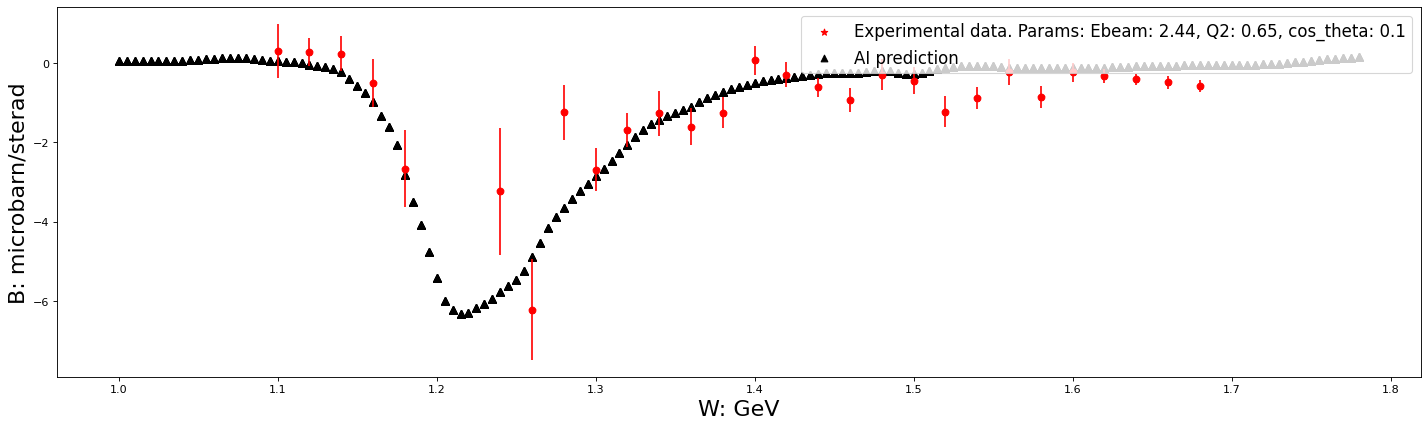

2024-12-03 16:17:46,823 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,828 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:46,830 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:46,833 : DEBUG : STREAM b'IDAT' 131 39694
2024-12-03 16:17:46,983 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,988 : DEBUG : STREAM b'IDAT' 41 39694


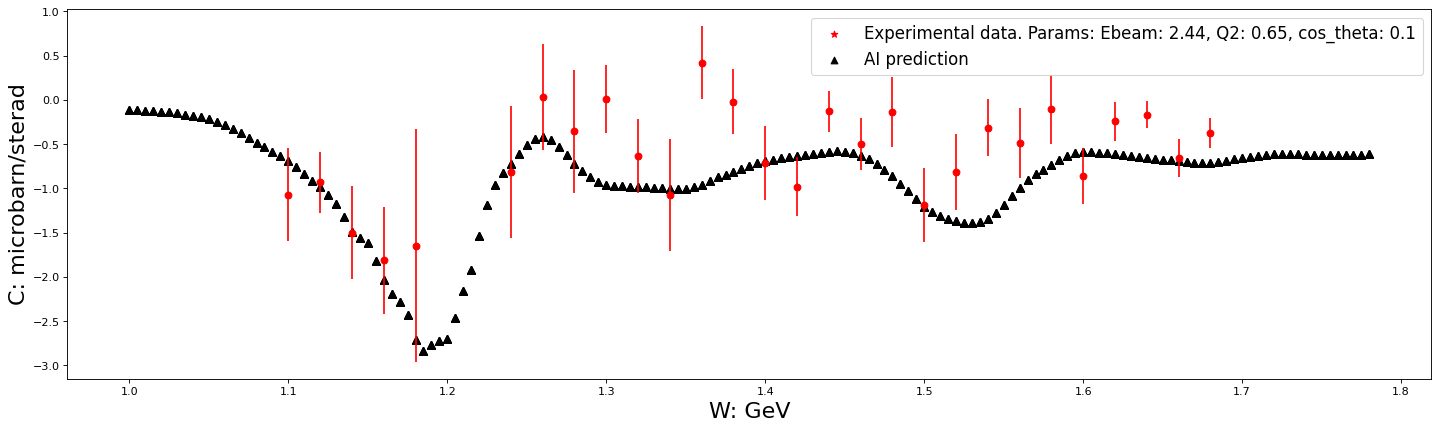

2


100%|██████████| 97/97 [00:09<00:00, 10.48it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
 24%|██▍       | 24/100 [04:08<13:07, 10.36s/it]


KeyboardInterrupt: 

In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False